In [1]:
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
from tqdm.auto import tqdm
from cmcrameri import cm
import geopandas as gpd
import pandas as pd
import seaborn as sns

import sys
from PIL import Image

from icesea2.functions import volume_to_sle
from icesea2.shearstress import ShearStressData, RasterLayer
from matplotlib.colors import LinearSegmentedColormap
from itertools import combinations
from shapely.geometry import Polygon

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
def apply_map(ax_dict, keys, gl=True):
    plot_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
    for key in keys:
        ax = ax_dict[key]
        ax.add_feature(cartopy.feature.LAND, zorder=1, color="grey")
        
        if gl is True:
            gridlines = ax.gridlines(draw_labels=True, linestyle="--")
            gridlines.right_labels = False
            gridlines.top_labels = False
        ax.set_extent(extent, crs=plot_crs)
    return ax_dict
    
def text(ax, text, x=0.5, y=0.95, fontsize=14):
    ax.text(
        x,
        y,
        text,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=fontsize, 
        color="white", 
        bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20
    )
def plot_map(figsize=None, grid=None, plot_crs=None, extent=None, text=None, gl=True):
    if plot_crs is None:
        plot_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
    if extent is None:
        extent = [-1053702.958, 3417796.998000001, -4560734.802, 1115265.2419999992]
    
    if grid is None:
        grid = [1,1]
    if figsize is None:
        figsize = [15, 8]
    fig = plt.figure(figsize=figsize)
    axes = np.empty((grid[0] * grid[1]), dtype=object)
    for idx in range(grid[0] * grid[1]):
        ax = fig.add_subplot(grid[0], grid[1], idx+1, projection=plot_crs)
        ax.add_feature(cartopy.feature.LAND, zorder=1, facecolor=(0,0,0,0.1),edgecolor=(0,0,0,0.5))
        if gl is True:
            gridlines = ax.gridlines(draw_labels=True, linestyle="--")
            gridlines.right_labels = False
            gridlines.top_labels = False
        ax.set_extent(extent, crs=plot_crs)
        if text:
            ax.text(0.5, 0.95, text, ha='center',va='center', transform=ax.transAxes, fontweight='bold', fontsize=14, color="white", bbox=dict(boxstyle='round', facecolor='black'), zorder=20)
        axes[idx] = ax
    axes = np.squeeze(np.reshape(axes, (grid[0], grid[1])))
    if grid[0] == grid[1] == 1:
        axes = ax
    return fig, axes

In [3]:
def param_plot(
    param_names,
    param_values,
    data=None,
    vmin=None,
    vmax=None,
    mirror=False,
    plot_density=False,
    plot_kwargs=None,
    ranges=None
):
    num_params = len(param_names)
    fig, axes = plt.subplots(num_params, num_params, figsize=[15, 15], dpi=300)

    param_values = (param_values - param_values.min(axis=0)) / (
        param_values.max(axis=0) - param_values.min(axis=0)
    )

    combos = list(combinations(np.arange(num_params), 2))
    for pa_index, pb_index in combos:
        ax = axes[pa_index, pb_index]
        ax.grid(False)

        param_x = param_values[:, pb_index]
        param_y = param_values[:, pa_index]
        """
        param_x_norm = (param_x - param_x.min(axis=0)) / (
            param_x.max(axis=0) - param_x.min(axis=0)
        )
        param_y_norm = (param_y - param_y.min(axis=0)) / (
            param_y.max(axis=0) - param_y.min(axis=0)
        )
        """
        if data is not None:
            z = data
            if vmin is None:
                vmin = data.min()
            if vmax is None:
                vmin = data.max()
        elif plot_density is True:
            try:
                xy = np.vstack([param_x, param_y])
                z = gaussian_kde(xy)(xy)
            except:
                z = "C0"
            vmin = None
            vmax = None
        else:
            z = "#005f73"
            vmin = None
            vmax = None

        if plot_kwargs is None:
            plot_kwargs = {}
        if "cmap" not in plot_kwargs:
            plot_kwargs["cmap"] = "BuPu"
        if "s" not in plot_kwargs:
            plot_kwargs["s"] = 6

        img = ax.scatter(param_x, param_y, c=z, **plot_kwargs)
        """
        img1 = ax.imshow(
            t_mask_sum_norm, 
            vmin=0, 
            vmax=1,
            cmap="GnBu", 
            origin="lower",
            extent=[0,1,0,1]
        )
        """
        if ((pa_index == 0) and (pb_index % 2 == 1)) and (
            (pb_index == 6) and (pa_index % 2 == 1)
        ):
            ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.xaxis.set_ticks_position("top")
            ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.yaxis.set_ticks_position("right")
        elif (pa_index == 0) and (pb_index % 2 == 1):
            ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.axes.yaxis.set_ticklabels([])
            ax.xaxis.set_ticks_position("top")
        elif (pb_index == num_params - 1) and (pa_index % 2 == 1):
            ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.axes.xaxis.set_ticklabels([])
            ax.yaxis.set_ticks_position("right")
        else:
            ax.axes.xaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([])

        ax = axes[pb_index, pa_index]
        if mirror is True:
            ax.grid(False)
            ax.scatter(param_values[pb_index], param_values[pa_index])
            if ((pa_index == 0) and (pb_index % 2 == 0)) and (
                (pb_index == 6) and (pa_index % 2 == 0)
            ):
                ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                ax.yaxis.set_ticks_position("left")
                ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                ax.xaxis.set_ticks_position("bottom")
            elif (pa_index == 0) and (pb_index % 2 == 0):
                ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                ax.axes.xaxis.set_ticklabels([])
                ax.yaxis.set_ticks_position("left")
            elif (pb_index == num_params - 1) and (pa_index % 2 == 0):
                ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                ax.axes.yaxis.set_ticklabels([])
                ax.xaxis.set_ticks_position("bottom")
            else:
                ax.axes.xaxis.set_ticklabels([])
                ax.axes.yaxis.set_ticklabels([])
        else:
            ax.axis("off")

    for index in range(num_params):
        ax = axes[index, index]
        ax.axis("off")
        ax.text(
            0.5,
            0.5,
            param_names[index],
            horizontalalignment="center",
            verticalalignment="center",
        )
    return fig, ax, img

In [4]:
ds = xr.open_dataset("../analytics/ice6g_icesheet_analytics.nc")
x = ds.x.values
y = ds.y.values
extent = [x.min(), x.max(), y.min(), y.max()]
crs = ds.rio.crs
times = [-22000,-20000,-18000,-16000]

ds.close()


In [5]:
plot_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
pgm_bf_gdf = gpd.read_file("../../data/ice_margins/batchelor/eurasia/mis6/best_estimate/margin.shp").to_crs(plot_crs.proj4_init)
lgm_bf_gdf = gpd.read_file("../../data/ice_margins/batchelor/eurasia/lgm/best_estimate/margin.shp").to_crs(plot_crs.proj4_init)

pgm_min_gdf = gpd.read_file("../../data/ice_margins/batchelor/eurasia/mis6/min/margin.shp").to_crs(plot_crs.proj4_init)
pgm_max_gdf = gpd.read_file("../../data/ice_margins/batchelor/eurasia/mis6/max/margin.shp").to_crs(plot_crs.proj4_init)

pgm_diff_gdf = gpd.GeoDataFrame(
    geometry = [pgm_max_gdf.iloc[1].geometry.symmetric_difference(pgm_min_gdf.iloc[1].geometry)],
    crs = pgm_max_gdf.crs
)

In [6]:


col_ds = xr.open_dataset("../reconstructions/col_er_reproj.nc")
lam_ds = xr.open_dataset("../reconstructions/lam_er_reproj.nc")

times = [-22000,-20000,-18000,-16000]

ice6g_ds = xr.open_dataset("../ice_models/ice6g_laea_5km_eurasia.nc")
glac1d_ds = xr.open_dataset("../ice_models/glac1d_laea_5km_eurasia.nc")
ice6g_icesheet_ds = xr.open_dataset("../runs/ice6g/ice6g_icesheet.nc")
glac1d_icesheet_ds = xr.open_dataset("../runs/glac1d/glac1d_icesheet.nc")
hist_match_ds = xr.open_dataset("../analytics/hist_match_lgm_lhs.nc")
nroy = hist_match_ds.nroy.values
hist_match_pgm_ds = xr.open_dataset("../analytics/history_match_pgm.nc")
nroy_pgm = hist_match_pgm_ds.nroy.values

ice6g = ice6g_ds.ice_thickness.sel(time=times).values
ice6g_icesheet_nroy_mean = ice6g_icesheet_ds.ice_thickness[nroy].values.mean(axis=0)
ice6g_icesheet_nroy_std = ice6g_icesheet_ds.ice_thickness[nroy].values.std(axis=0)
ice6g_icesheet_nroy_diff = ice6g_icesheet_nroy_mean - ice6g
ice6g_icesheet_nroy_diff[ice6g_icesheet_nroy_mean==0] = 0
ice6g_icesheet_nroy_diff[ice6g==0] = 0

glac1d = glac1d_ds.ice_thickness.sel(time=times).values
glac1d_icesheet_nroy_mean = glac1d_icesheet_ds.ice_thickness[nroy].values.mean(axis=0)
glac1d_icesheet_nroy_std = glac1d_icesheet_ds.ice_thickness[nroy].values.std(axis=0)
glac1d_icesheet_nroy_diff = glac1d_icesheet_nroy_mean - glac1d
glac1d_icesheet_nroy_diff[glac1d_icesheet_nroy_mean==0] = 0
glac1d_icesheet_nroy_diff[glac1d==0] = 0



In [7]:
batchelor_topo_0_ds = xr.open_dataset("../analytics/batchelor_topo_0_analytics.nc")
batchelor_topo_1_ds = xr.open_dataset("../analytics/batchelor_topo_1_analytics.nc")
topo_0_ds = xr.open_dataset("../runs/batchelor/topo_iteration_0/inputs/topography/topography.nc")

batchelor_topo_0_ice_mean = batchelor_topo_0_ds.ice_thickness_mean.sel(time=[-140000]).values
batchelor_topo_0_ice_std = batchelor_topo_0_ds.ice_thickness_std.sel(time=[-140000]).values

batchelor_topo_1_ice_mean = batchelor_topo_1_ds.ice_thickness_mean.sel(time=[-140000]).values
batchelor_topo_1_ice_std = batchelor_topo_1_ds.ice_thickness_std.sel(time=[-140000]).values

batchelor_topo_ice_mean_diff =  batchelor_topo_0_ice_mean - batchelor_topo_1_ice_mean
batchelor_topo_ice_std_diff =  batchelor_topo_0_ice_std - batchelor_topo_1_ice_std

batchelor_topo_0_topo_mean = topo_0_ds.z.values
batchelor_topo_1_topo_mean = batchelor_topo_1_ds.bedrock_topography_mean.values[0]
batchelor_topo_1_topo_std = batchelor_topo_1_ds.bedrock_topography_std.values[0]
batchelor_topo_topo_diff = batchelor_topo_0_topo_mean - batchelor_topo_1_topo_mean

In [8]:
batchelor_icesheet_ds = xr.open_dataset("../runs/batchelor/batchelor_topo_1.nc")
hist_match_ds = xr.open_dataset("../analytics/history_match_pgm.nc")
nroy_pgm = hist_match_ds.nroy.values

batchelor_icesheet_mean = batchelor_icesheet_ds.ice_thickness.sel(time=[-140000]).values.mean(axis=0)
batchelor_icesheet_std = batchelor_icesheet_ds.ice_thickness.sel(time=[-140000]).values.std(axis=0)

batchelor_icesheet_nroy_mean = batchelor_icesheet_ds.ice_thickness.sel(time=[-140000])[nroy_pgm].values.mean(axis=0)
batchelor_icesheet_nroy_std = batchelor_icesheet_ds.ice_thickness.sel(time=[-140000])[nroy_pgm].values.std(axis=0)

batchelor_icesheet_mean_diff = batchelor_icesheet_nroy_mean - batchelor_icesheet_mean
batchelor_icesheet_std_diff = batchelor_icesheet_nroy_std - batchelor_icesheet_std

In [9]:
ice6g_analytics_ds = xr.open_dataset("../analytics/ice6g_analytics.nc")
glac1d_analytics_ds = xr.open_dataset("../analytics/glac1d_analytics.nc")
ice6g_icesheet_analytics_ds = xr.open_dataset("../analytics/ice6g_icesheet_analytics.nc")
glac1d_icesheet_analytics_ds = xr.open_dataset("../analytics/glac1d_icesheet_analytics.nc")

batchelor_topo_1_analytics_ds = xr.open_dataset("../analytics/batchelor_topo_1_analytics.nc")

In [10]:
pgm_vols = batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()
pgm_nroy_vols = batchelor_topo_1_analytics_ds.ice_volume_sle.values[nroy_pgm]

In [11]:
x_coords = ice6g_ds.x.values
y_coords = ice6g_ds.y.values
projection = '+ellps=WGS84 +proj=laea +lon_0=0.0 +lat_0=90 +x_0=0.0 +y_0=0.0 +no_defs'
margin = gpd.read_file("/nfs/annie/cm15ogp/phd/data/ice_margins/batchelor_quickfix/-140000/margin.shp")

# Paper Figures

## Figure 1: Sites

In [ ]:
#! mkdir paper1_plots/f1_site

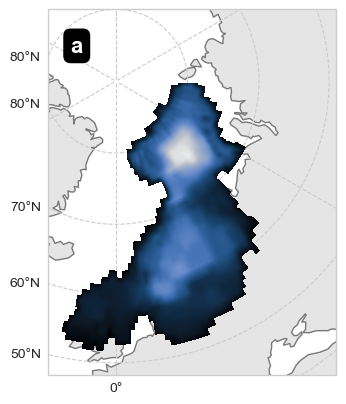

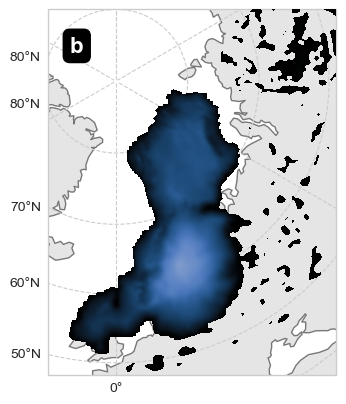

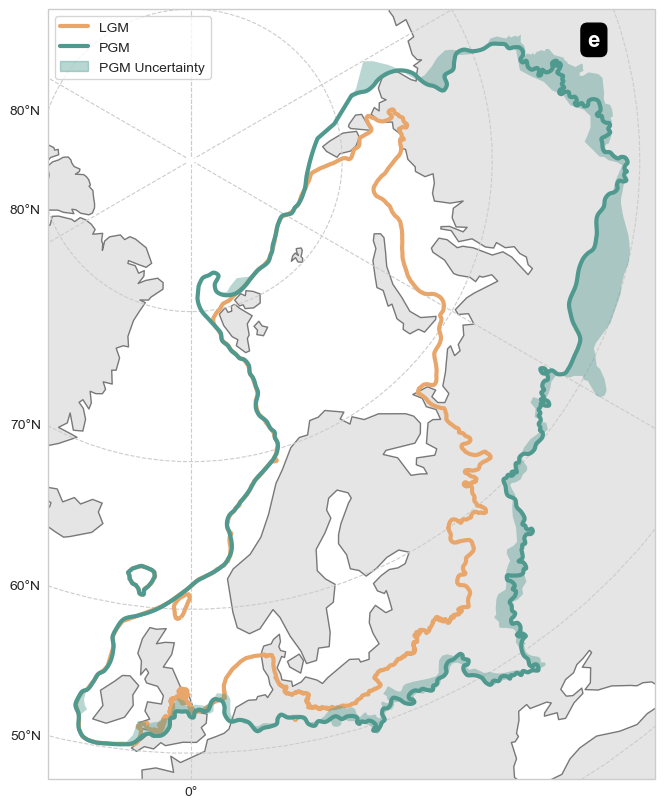

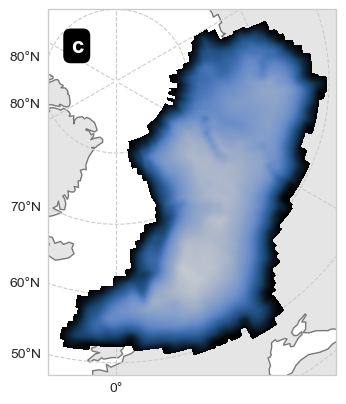

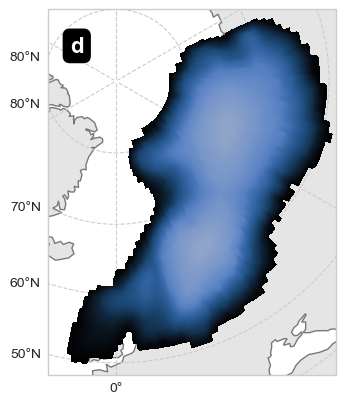

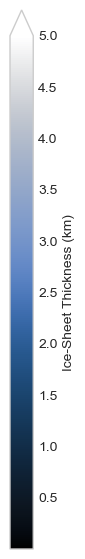

In [32]:
ice6g_times = ice6g_ds.time
glac1d_times = glac1d_ds.time
ice6g_sum = np.sum(ice6g_ds.ice_thickness.values, axis=(1,2))
glac1d_sum = np.sum(glac1d_ds.ice_thickness.values, axis=(1,2))

plot_array_dict = dict(
    a = ice6g_ds.ice_thickness.sel(time=ice6g_times[ice6g_sum.argmax()]).values,
    b = glac1d_ds.ice_thickness.sel(time=glac1d_times[glac1d_sum.argmax()]).values,
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=np.array([4,5])*0.95)
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/f1_site/f1_site_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plot_map(figsize=[4*2,5*2])

lgm_bf_gdf.plot(
    ax=ax, 
    facecolor=(0,0,0,0), 
    edgecolor=(0.91,0.65,0.42), 
    linewidth=3,
    zorder=10
)
pgm_bf_gdf.plot(
    ax=ax, 
    facecolor=(0,0,0,0), 
    edgecolor=(0.31,0.60,0.56), 
    linewidth=3,
    zorder=10
)
pgm_diff_gdf.plot(
    ax=ax, 
    facecolor=(0.31,0.60,0.56,0.4), 
    edgecolor=(0,0,0,0), 
    linewidth=3,
    zorder=10
)
from matplotlib.lines import Line2D
legend_data = [
    Line2D([0], [0], color=(0.91,0.65,0.42), label="LGM", lw=3),
    Line2D([0], [0], color=(0.31,0.60,0.56), label="PGM", lw=3),
    mpatches.Patch(color=(0.31,0.60,0.56,0.4), label="PGM Uncertainty"),
]
ax.legend(
    handles=legend_data,
    loc='upper left', 
    frameon=True,
)

text(ax, "e", x=0.9, y=0.96, fontsize=16)
fig.savefig(f"../plots/f1_site/f1_site_c.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    d = col_ds.ice_thickness.values,
    e = lam_ds.ice_thickness.values,
)
labels = ['c', 'd']
for idx, (label, plot_array) in enumerate(plot_array_dict.items()):
    fig, ax = plot_map(figsize=np.array([4,5])*0.95)
    text(ax, labels[idx], x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/f1_site/f1_site_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,7])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="max", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/f1_site/f1_site_1.png", dpi=300, bbox_inches="tight")


In [33]:
plot_ext = "../plots/f1_site/f1_site_"

plot_a_width, plot_a_height = Image.open(f"{plot_ext}a.png").size
plot_c_width, plot_c_height = Image.open(f"{plot_ext}c.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size

"""
Layout
A1
"""
total_width = plot_a_width*2 + plot_c_width + cbar_width
total_height = plot_c_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*(plot_c_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (plot_a_width,0))
im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (plot_a_width+plot_c_width,0))

im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (0,plot_a_height))
im = Image.open(f"{plot_ext}e.png")
new_im.paste(im, (plot_a_width+plot_c_width,plot_a_height))

im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_a_width*2+plot_c_width,cbar_offset))

new_im.save('../plots/f1_site.png')

# Figure 2: Shear Stress Map

In [9]:
#! mkdir paper1_plots/f2_ss_map

In [26]:
ss_map_shp = "/nfs/annie/cm15ogp/phd/data/shear_stress/eurasia/regions.shp"
ss_map = ShearStressData.from_shp(ss_map_shp)

epsg:4326


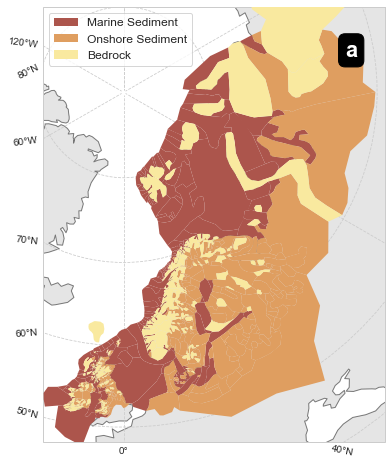

In [34]:
fig, ax = plot_map()

category_args = {'marine_sediment': {'label': 'Marine Sediment', 'color': '#AC554C'},
                'onshore_sediment': {'label': 'Onshore Sediment', 'color': '#DF9E60'},
                'bedrock': {'label': 'Bedrock', 'color': '#F9E99F'},
                'ice_stream_hybrid': {'label': 'Ice Stream Hybrid', 'color': '#56355B'},
                'ice_stream': {'label': 'Ice Stream', 'color': '#452B1E'},}
ss_map.plot(layers=['sediment'], ax=ax, category_args=category_args)
text(ax=ax, text="a", x=0.9, y=0.9, fontsize=22)

fig.savefig(f"paper1_plots/f2_ss_map/f2_ss_map_a.png", dpi=300, bbox_inches="tight")

epsg:4326
epsg:4326
epsg:4326


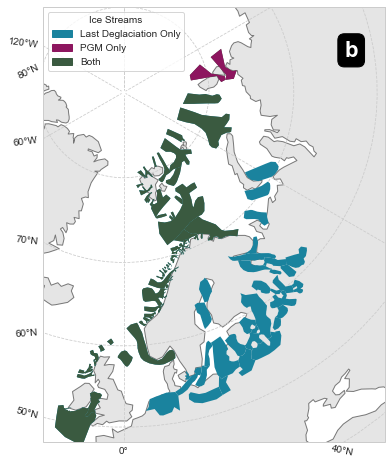

In [45]:
lgm_is_colour = '#1A839E'
pgm_is_colour = '#8D165F'
lgm_pgm_is_colour = '#3a5a40'

fig, ax = plot_map()

category_args = {'ice_stream': {'label': 'Ice Stream', 'color': lgm_is_colour},}
ss_map.plot(layers=['lgm_ice_streams'], ax=ax, category_args=category_args)

category_args = {'ice_stream': {'label': 'Ice Stream', 'color': lgm_pgm_is_colour},}
ss_map.plot(layers=['pgm_ice_streams'], ax=ax, category_args=category_args)

category_args = {'ice_stream': {'label': 'Ice Stream', 'color': pgm_is_colour},}
ss_map.plot(ids=[904, 905], ax=ax, category_args=category_args)


legend_data = [
    mpatches.Patch(color=lgm_is_colour, label='Last Deglaciation Only'),
    mpatches.Patch(color=pgm_is_colour, label='PGM Only'),
    mpatches.Patch(color=lgm_pgm_is_colour, label='Both'),
]
ax.legend(
    handles=legend_data,
    title="Ice Streams",
    loc='upper left', 
    frameon=True,
)


text(ax=ax, text="b", x=0.9, y=0.9, fontsize=22)

fig.savefig(f"paper1_plots/f2_ss_map/f2_ss_map_b.png", dpi=300, bbox_inches="tight")

In [46]:
plot_ext = "paper1_plots/f2_ss_map/f2_ss_map_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size

"""
Layout
rAB1C2D3
rEF1G2H3
"""
total_width = plot_width*2
total_height = plot_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_width,0))

new_im.save('paper1_plots/f2_ss_map.png')

# ICESHEET Inputs

## Figure 3: Shear Stress

In [53]:
! mkdir paper1_plots/f3_ss_basal

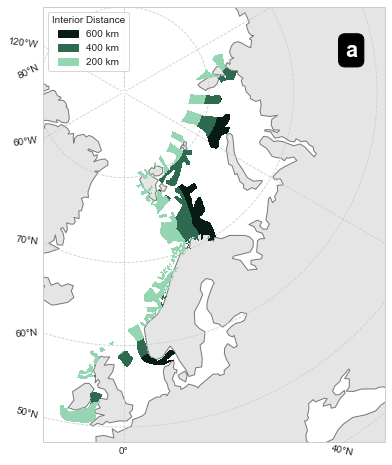

In [54]:
pgm_streams = ss_map.to_mask(x_coords, y_coords, projection, layers=["pgm_ice_streams"]).mask
fig, ax = plot_map()
ci_colors = ["#081C15", "#2D6A4F", "#95D5B2"]
for idx, dist in enumerate([600,400,200]):
    plt_img = pgm_streams * RasterLayer.ice_stream_gradient_mask(margin, x_coords, y_coords, projection, dist, order=0).raster.astype(float)
    plt_img[0,0] = 0.001
    img = ax.imshow(
        np.ma.masked_where(plt_img==0, plt_img),
        extent=extent,
        origin="lower",
        cmap=LinearSegmentedColormap.from_list("", [(1,0,0,1),ci_colors[idx]]),
        zorder=10,
        interpolation="none"
    )
    
legend_data = [
    mpatches.Patch(color='#081C15', label='600 km'),
    mpatches.Patch(color='#2D6A4F', label='400 km'),
    mpatches.Patch(color='#95D5B2', label='200 km'),
]
ax.legend(
    handles=legend_data,
    title="Interior Distance",
    loc='upper left', 
    frameon=True,
)

text(ax=ax, text="a", x=0.9, y=0.9, fontsize=22)
fig.savefig(f"paper1_plots/f3_ss_basal/f3_ss_basal_a.png", dpi=300, bbox_inches="tight")

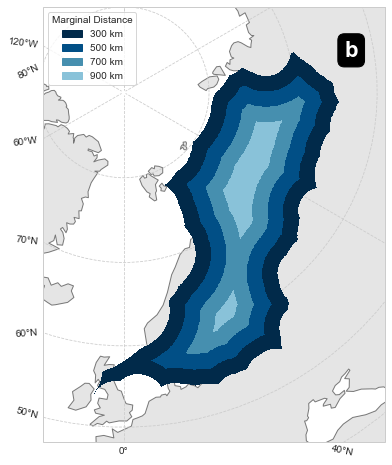

In [56]:
fig, ax = plot_map()
ci_colors = ["#012A4A", "#014F86", "#468FAF", "#89C2D9"]
for idx, dist in enumerate([300,500,700,900]):
    plt_img = RasterLayer.cold_ice_mask(margin, x_coords, y_coords, projection, dist, 400, order=0).raster.astype(float)
    plt_img[0,0] = 0.001
    img = ax.imshow(
        np.ma.masked_where(plt_img==0, plt_img),
        extent=extent,
        origin="lower",
        cmap=LinearSegmentedColormap.from_list("", [(1,0,0,1),ci_colors[idx]]),
        zorder=10,
        interpolation="none"
    )
    
legend_data = [
    mpatches.Patch(color='#012A4A', label='300 km'),
    mpatches.Patch(color='#014F86', label='500 km'),
    mpatches.Patch(color='#468FAF', label='700 km'),
    mpatches.Patch(color='#89C2D9', label='900 km'),
]
ax.legend(
    handles=legend_data,
    title="Marginal Distance",
    loc='upper left', 
    frameon=True,
)

text(ax=ax, text="b", x=0.9, y=0.9, fontsize=22)
fig.savefig(f"paper1_plots/f3_ss_basal/f3_ss_basal_b.png", dpi=300, bbox_inches="tight")


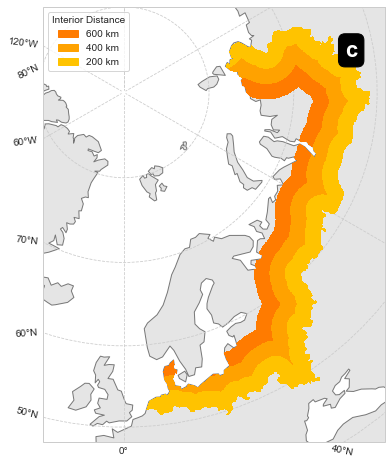

In [57]:
fig, ax = plot_map()
ci_colors = ["#FF7B00", "#FFA200", "#FFC300"]
for idx, dist in enumerate([600,400,200]):
    plt_img = RasterLayer.hybrid_ice_stream(margin, x_coords, y_coords, projection, dist).raster.astype(float)
    plt_img[0,0] = 0.001
    img = ax.imshow(
        np.ma.masked_where(plt_img==0, plt_img),
        extent=extent,
        origin="lower",
        cmap=LinearSegmentedColormap.from_list("", [(1,0,0,1),ci_colors[idx]]),
        zorder=10,
        interpolation="none"
    )
    
legend_data = [
    mpatches.Patch(color='#FF7B00', label='600 km'),
    mpatches.Patch(color='#FFA200', label='400 km'),
    mpatches.Patch(color='#FFC300', label='200 km'),
]
ax.legend(
    handles=legend_data,
    title="Interior Distance",
    loc='upper left', 
    frameon=True,
)

text(ax=ax, text="c", x=0.9, y=0.9, fontsize=22)

fig.savefig(f"paper1_plots/f3_ss_basal/f3_ss_basal_c.png", dpi=300, bbox_inches="tight")

In [60]:
plot_ext = "paper1_plots/f3_ss_basal/f3_ss_basal_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size

total_width = plot_width*3
total_height = plot_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_width,0))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (plot_width*2,0))

new_im.save('paper1_plots/f3_ss_basal.png')

## Figure 4: Last Deglaciation Volumes

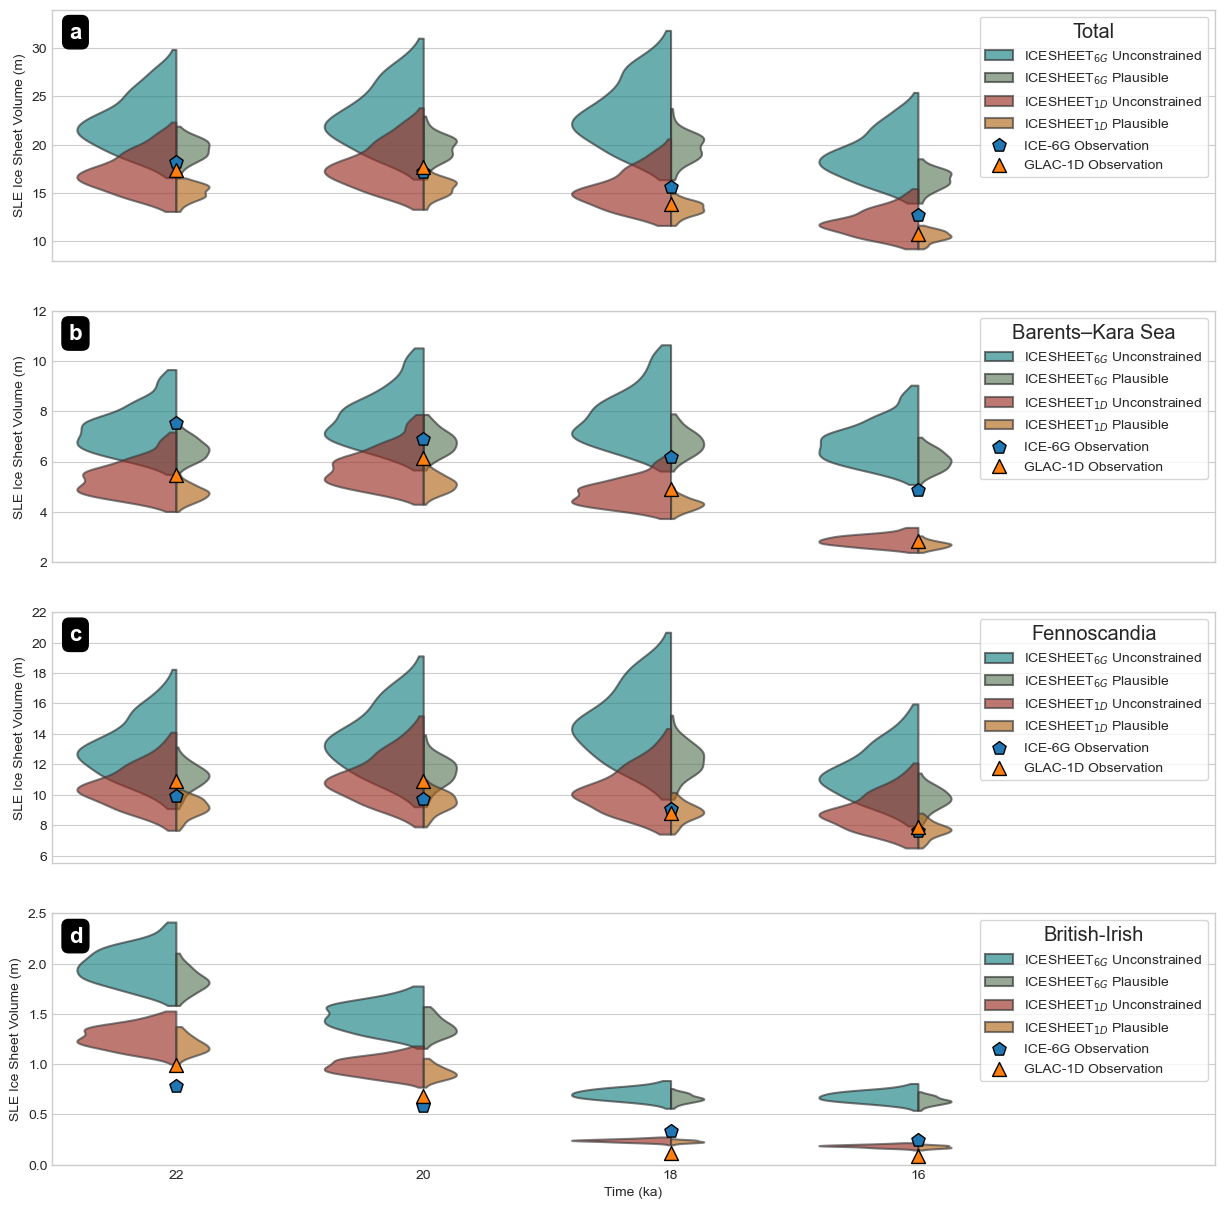

In [32]:
fig, ax = plt.subplots(4,1, figsize=[15,15])
palettes = [["#0a9396", "#588157"], ["#ae2012", "#ca6702"]]
for ds_idx, ds in enumerate([ice6g_icesheet_analytics_ds, glac1d_icesheet_analytics_ds]):
    times = np.concatenate(
        [
            np.concatenate([np.ones((200))*time for time in [-22,-20,-18,-16]]), 
            np.concatenate([np.ones((np.sum(nroy)))*time for time in [-22,-20,-18,-16]])
        ]
    )

    volumes = np.concatenate(
        [
            ds.ice_volume.values.T.flatten(), 
            ds.ice_volume.values[nroy].T.flatten()
        ]
    )
    volumes = volume_to_sle(volumes)

    hist_matched = [False for index in range(200*4)] + [True for index in range(np.sum(nroy)*4)]
    data = {
        'Time': times, 
        'Ice Sheet Volume': volumes,
        'History Matched': hist_matched

    }
    df = pd.DataFrame(data = data)

    sns.violinplot(
        ax = ax[0],
        x = "Time",
        y = "Ice Sheet Volume",
        hue="History Matched",
        data=df,
        split=True,
        scale = "count",
        inner=None,
        palette = palettes[ds_idx],
        cut=0,
        gridsize=10000
    )

for idx, region in enumerate(["bks", "f", "bi"]):
    
    for ds_idx, ds in enumerate([ice6g_icesheet_analytics_ds, glac1d_icesheet_analytics_ds]):
        times = np.concatenate(
            [
                np.concatenate([np.ones((200))*time for time in [-22,-20,-18,-16]]), 
                np.concatenate([np.ones((np.sum(nroy)))*time for time in [-22,-20,-18,-16]])
            ]
        )
        
        volumes = np.concatenate(
            [
                ds.region_ice_volume.sel(region=region).values.T.flatten(), 
                ds.region_ice_volume.sel(region=region).values[nroy].T.flatten()
            ]
        )
        volumes = volume_to_sle(volumes)
        
        hist_matched = [False for index in range(200*4)] + [True for index in range(np.sum(nroy)*4)]
        data = {
            'Time': times, 
            'Ice Sheet Volume': volumes,
            'History Matched': hist_matched

        }
        df = pd.DataFrame(data = data)

        sns.violinplot(
            ax = ax[idx+1],
            x = "Time",
            y = "Ice Sheet Volume",
            hue="History Matched",
            data=df,
            split=True,
            scale = "count",
            inner=None,
            palette = palettes[ds_idx],
            cut=0,
            gridsize=10000
        )
        
for idx, axis in enumerate(ax):
    if idx == 2:
        axis.set_xlabel("")
    if idx == 3:
        axis.set_xlabel("Time (ka)")
    axis.set_ylabel("SLE Ice Sheet Volume (m)")
    for violin in axis.collections:
        violin.set_alpha(0.65)

        
ax[0].scatter(
    [0,1,2,3], 
    ice6g_analytics_ds.ice_volume_sle, 
    marker="p",
    s=100,
    edgecolors='black',
    zorder=20
)
ax[0].scatter(
    [0,1,2,3], 
    glac1d_analytics_ds.ice_volume_sle, 
    marker="^",
    s=100,
    edgecolors='black',
    zorder=20
) 
    
for idx, region in enumerate(["bks", "f", "bi"]):
    ax[idx+1].scatter(
        [0,1,2,3], 
        ice6g_analytics_ds.region_ice_volume_sle.sel(region=region), 
        marker="p",
        s=100,
        edgecolors='black',
        zorder=20
    )
    ax[idx+1].scatter(
        [0,1,2,3], 
        glac1d_analytics_ds.region_ice_volume_sle.sel(region=region), 
        marker="^",
        s=100,
        edgecolors='black',
        zorder=20
    ) 
region_names = [
    "Total", "Barents–Kara Sea", "Fennoscandia", "British-Irish"
]
ylim = [
    [8,34],
    [2,12],
    [5.5,22],
    [0,2.5]
]

for idx, axis in enumerate(ax):
    axis.set_xlim([-0.5,4.2])
    legend_data = [
        axis.collections[0],
        axis.collections[5],
        axis.collections[-4],
        axis.collections[-3],
        axis.collections[-2],
        axis.collections[-1]
    ]
    axis.legend(
        handles=legend_data, 
        title=region_names[idx], 
        title_fontsize='x-large',
        loc='upper right', 
        labels=[
            "ICESHEET$_{6G}$ Unconstrained", 
            "ICESHEET$_{6G}$ Plausible", 
            "ICESHEET$_{1D}$ Unconstrained", 
            "ICESHEET$_{1D}$ Plausible", 
            "ICE-6G Observation", 
            "GLAC-1D Observation"
        ],
        frameon=True
    )
    axis.set_ylim(ylim[idx])
    
for axis in ax[0:3]:
    axis.set_xticklabels([])
    axis.set_xlabel("")
ax[3].set_xticklabels([22,20,18,16])

for idx, label in enumerate(["a", "b", "c", "d"]):
    text(ax[idx], label, x=0.02, y=0.91, fontsize=16)
    
fig.savefig("../plots/f4_ld_nroy_dists.png", dpi=300, bbox_inches="tight")


## Figure 5: Last Deglaciation Spatial

In [77]:
#! mkdir paper1_plots/f5_ld_spatial

/tmp/ipykernel_544/2689935172.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


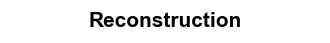

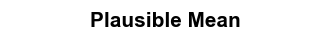

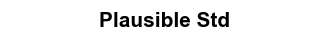

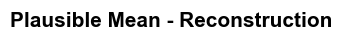

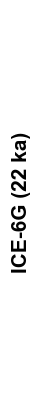

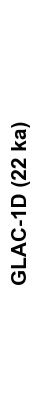

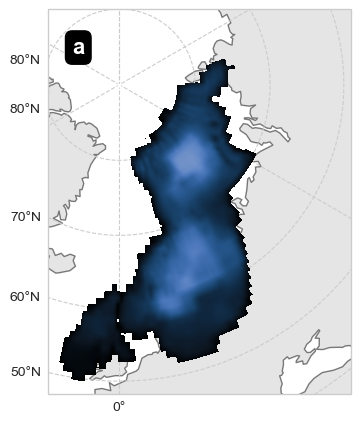

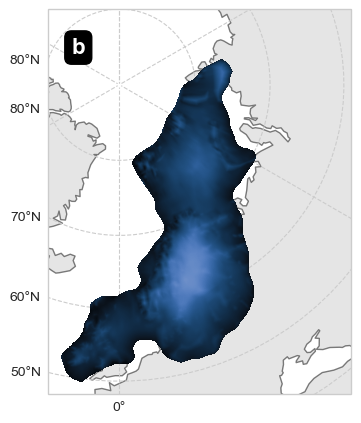

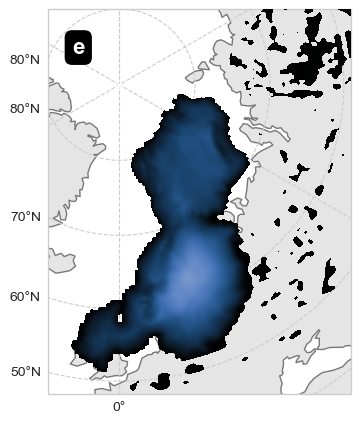

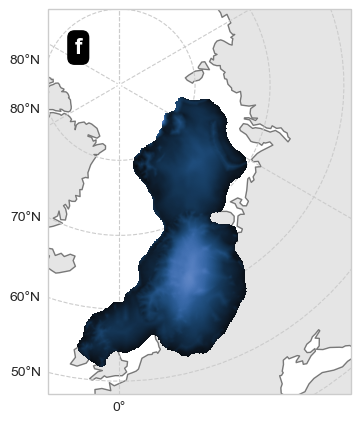

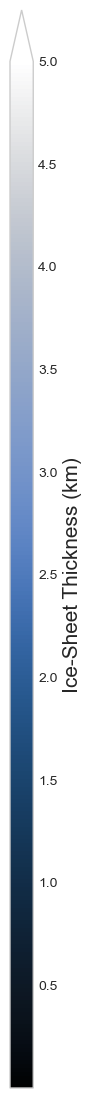

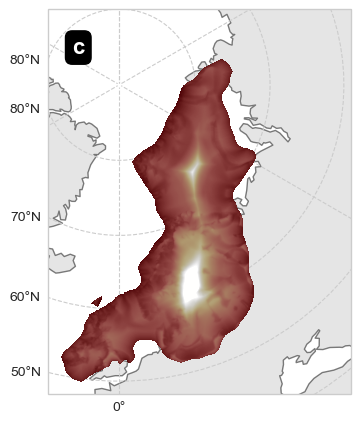

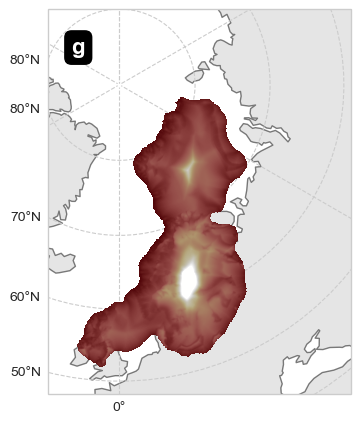

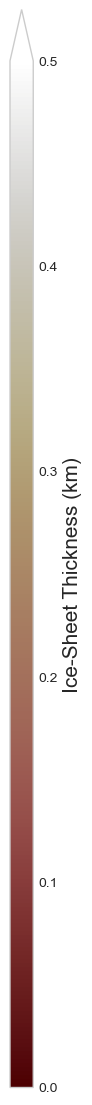

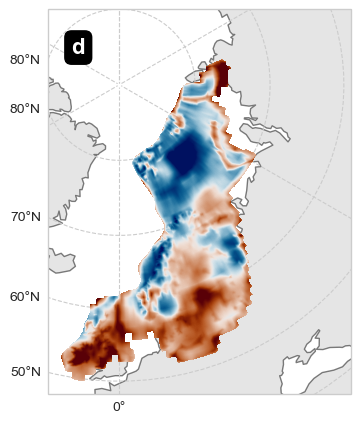

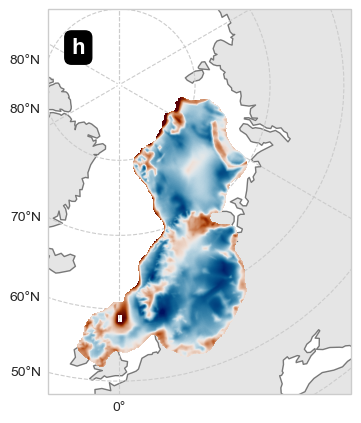

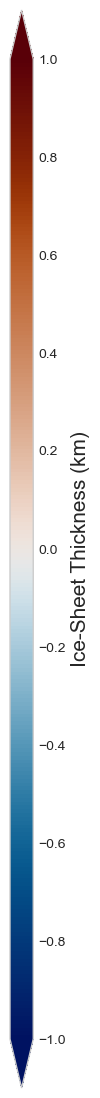

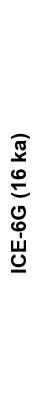

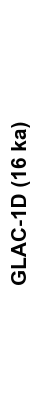

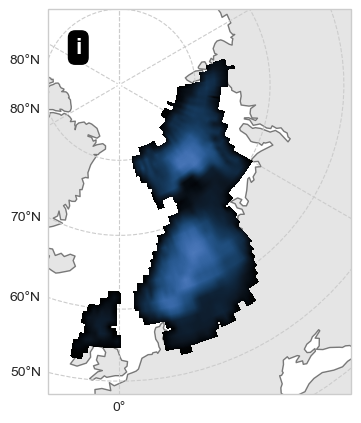

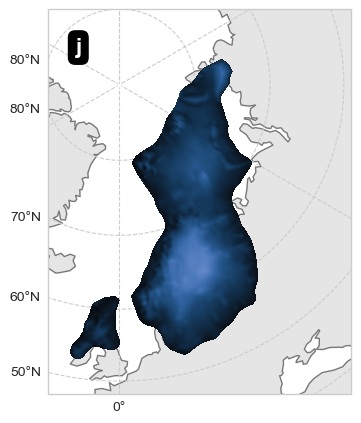

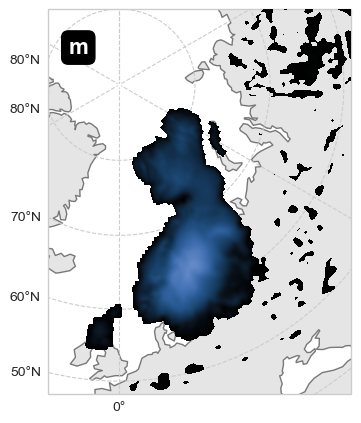

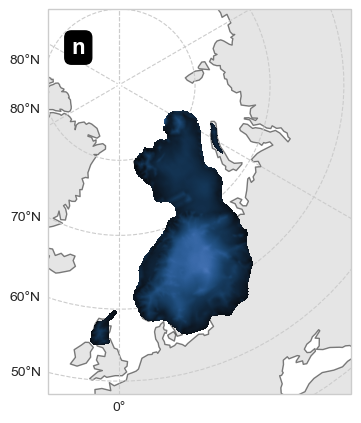

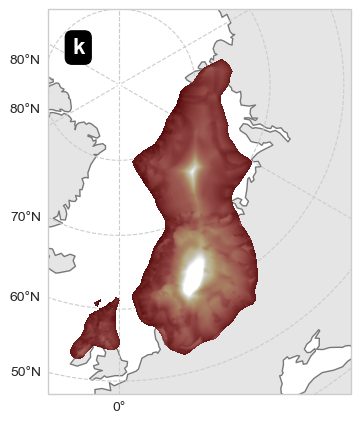

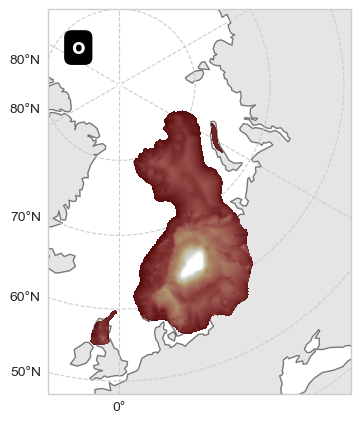

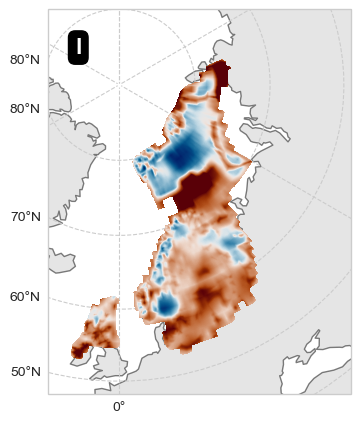

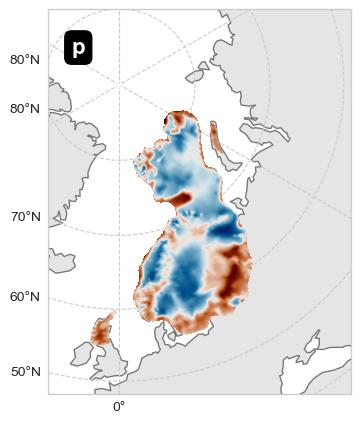

In [27]:
columns = [
    "Reconstruction",
    "Plausible Mean",
    "Plausible Std",
    "Plausible Mean - Reconstruction",
]
for index, column in enumerate(columns):
    fig, ax = plt.subplots(figsize=[4, .3])
    ax.text(
        0.5,
        0.5,
        s=column,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=0
    )
    ax.axis('off')
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_tc{index+1}.png", dpi=300, bbox_inches="tight")

rows = [
    "ICE-6G (22 ka)",
    "GLAC-1D (22 ka)"
]
for index, row in enumerate(rows):
    fig, ax = plt.subplots(figsize=[.3,5])
    ax.text(
        0.5,
        0.5,
        s=row,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=90
    )
    ax.axis('off')
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_22_tr{index+1}.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    a = ice6g[0],
    b = ice6g_icesheet_nroy_mean[0],
    e = glac1d[0],
    f = glac1d_icesheet_nroy_mean[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_22_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    extend="max", 
    shrink=0.7,
    aspect=40,
).set_label(label="Ice-Sheet Thickness (km)",size=15)
fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_1.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    c = ice6g_icesheet_nroy_std[0],
    g = glac1d_icesheet_nroy_std[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 0.5,
        vmin = 0,
        cmap=cm.bilbao_r
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_22_{label}.png", dpi=300, bbox_inches="tight")
    
fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,1,num=11), 
    extend="max", 
    shrink=0.7,
    aspect=40,
).set_label(label="Ice-Sheet Thickness (km)",size=15)
fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_2.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    d = ice6g_icesheet_nroy_diff[0],
    h = glac1d_icesheet_nroy_diff[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin=-1,
        cmap=cm.vik
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_22_{label}.png", dpi=300, bbox_inches="tight")
    
fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-1,1,num=11), 
    extend="both", 
    shrink=0.7,
    aspect=40,
).set_label(label="Ice-Sheet Thickness (km)",size=15)
fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_3.png", dpi=300, bbox_inches="tight")

rows = [
    "ICE-6G (16 ka)",
    "GLAC-1D (16 ka)"
]
for index, row in enumerate(rows):
    fig, ax = plt.subplots(figsize=[.3,5])
    ax.text(
        0.5,
        0.5,
        s=row,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=90
    )
    ax.axis('off')
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_16_tr{index+1}.png", dpi=300, bbox_inches="tight")
    
plot_array_dict = dict(
    i = ice6g[-1],
    j = ice6g_icesheet_nroy_mean[-1],
    m = glac1d[-1],
    n = glac1d_icesheet_nroy_mean[-1],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_16_{label}.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    k = ice6g_icesheet_nroy_std[-1],
    o = glac1d_icesheet_nroy_std[-1],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 0.5,
        vmin = 0,
        cmap=cm.bilbao_r
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_16_{label}.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    l = ice6g_icesheet_nroy_diff[-1],
    p = glac1d_icesheet_nroy_diff[-1],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin=-1,
        cmap=cm.vik
    )
    fig.savefig(f"../plots/f5_ld_spatial/f5_ld_spatial_16_{label}.png", dpi=300, bbox_inches="tight")

In [28]:
plot_ext = "../plots/f5_ld_spatial/f5_ld_spatial_"

plot_width, plot_height = Image.open(f"{plot_ext}22_a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size
trow_width, trow_height = Image.open(f"{plot_ext}22_tr1.png").size
tcol_width, tcol_height = Image.open(f"{plot_ext}tc1.png").size

total_width = plot_width*4 + cbar_width*3 + trow_width
total_height = plot_height*4 + tcol_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*total_height - 0.5*cbar_height)

im = Image.open(f"{plot_ext}22_tr1.png")
new_im.paste(im, (0,tcol_height))
im = Image.open(f"{plot_ext}22_tr2.png")
new_im.paste(im, (0,tcol_height+plot_height))
im = Image.open(f"{plot_ext}16_tr1.png")
new_im.paste(im, (0,tcol_height+plot_height*2))
im = Image.open(f"{plot_ext}16_tr2.png")
new_im.paste(im, (0,tcol_height+plot_height*3))

im = Image.open(f"{plot_ext}tc1.png")
new_im.paste(im, (trow_width*2,0))
im = Image.open(f"{plot_ext}tc2.png")
new_im.paste(im, (trow_width*2+plot_width,0))
im = Image.open(f"{plot_ext}tc3.png")
new_im.paste(im, (trow_width*2+plot_width*2+cbar_width,0))
im = Image.open(f"{plot_ext}tc4.png")
new_im.paste(im, (trow_width*2+plot_width*3+cbar_width*2,0))

im = Image.open(f"{plot_ext}22_a.png")
new_im.paste(im, (trow_width,tcol_height))
im = Image.open(f"{plot_ext}22_b.png")
new_im.paste(im, (trow_width+plot_width,tcol_height))
im = Image.open(f"{plot_ext}22_c.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height))
im = Image.open(f"{plot_ext}22_d.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width*2,tcol_height))

im = Image.open(f"{plot_ext}22_e.png")
new_im.paste(im, (trow_width,plot_height+tcol_height))
im = Image.open(f"{plot_ext}22_f.png")
new_im.paste(im, (trow_width+plot_width,plot_height+tcol_height))
im = Image.open(f"{plot_ext}22_g.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,plot_height+tcol_height))
im = Image.open(f"{plot_ext}22_h.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width*2,plot_height+tcol_height))

im = Image.open(f"{plot_ext}16_i.png")
new_im.paste(im, (trow_width,plot_height*2+tcol_height))
im = Image.open(f"{plot_ext}16_j.png")
new_im.paste(im, (trow_width+plot_width,plot_height*2+tcol_height))
im = Image.open(f"{plot_ext}16_k.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,plot_height*2+tcol_height))
im = Image.open(f"{plot_ext}16_l.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width*2,plot_height*2+tcol_height))

im = Image.open(f"{plot_ext}16_m.png")
new_im.paste(im, (trow_width,plot_height*3+tcol_height))
im = Image.open(f"{plot_ext}16_n.png")
new_im.paste(im, (trow_width+plot_width,plot_height*3+tcol_height))
im = Image.open(f"{plot_ext}16_o.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,plot_height*3+tcol_height))
im = Image.open(f"{plot_ext}16_p.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width*2,plot_height*3+tcol_height))

im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}2.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}3.png")
new_im.paste(im, (trow_width+plot_width*4+cbar_width*2,tcol_height+cbar_offset))


new_im.save('../plots/f5_ld_spatial.png')

## Figure 6: Last Deglaciation Implausibility

In [33]:
ld_hist_match_ds = xr.open_dataset("../analytics/hist_match_lgm_lhs.nc")
ld_nroy = ld_hist_match_ds.nroy.values
ld_imp = ld_hist_match_ds.implausibility.values

ld_nroy_time = ld_hist_match_ds.nroy_time.values
ld_imp_time = ld_hist_match_ds.implausibility_time.values

ld_param_vals = pd.read_csv("../runs/glac1d/lhs_values.csv").values
ld_param_names = pd.read_csv("../runs/glac1d/lhs_values.csv").columns

ld_lhs_df = pd.read_csv("../runs/glac1d/lhs_values.csv")
ld_param_vals = ld_lhs_df.to_numpy()

In [106]:
! mkdir paper1_plots/f6_ld_imp

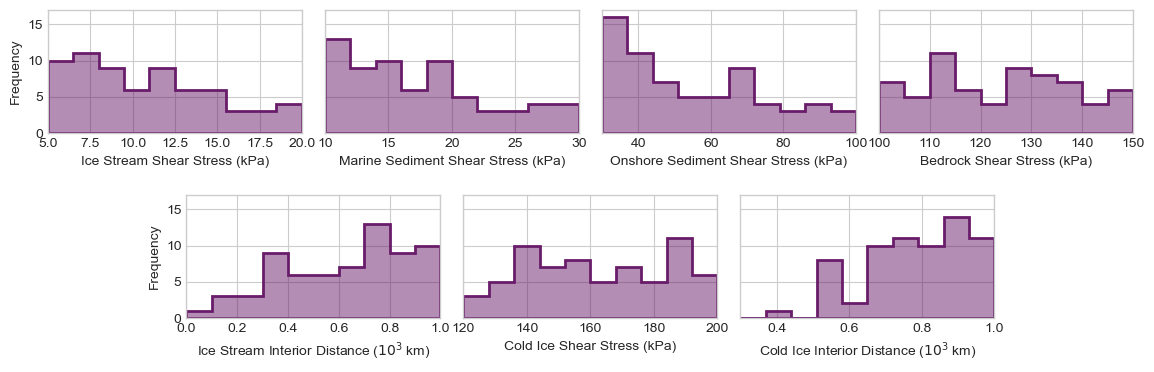

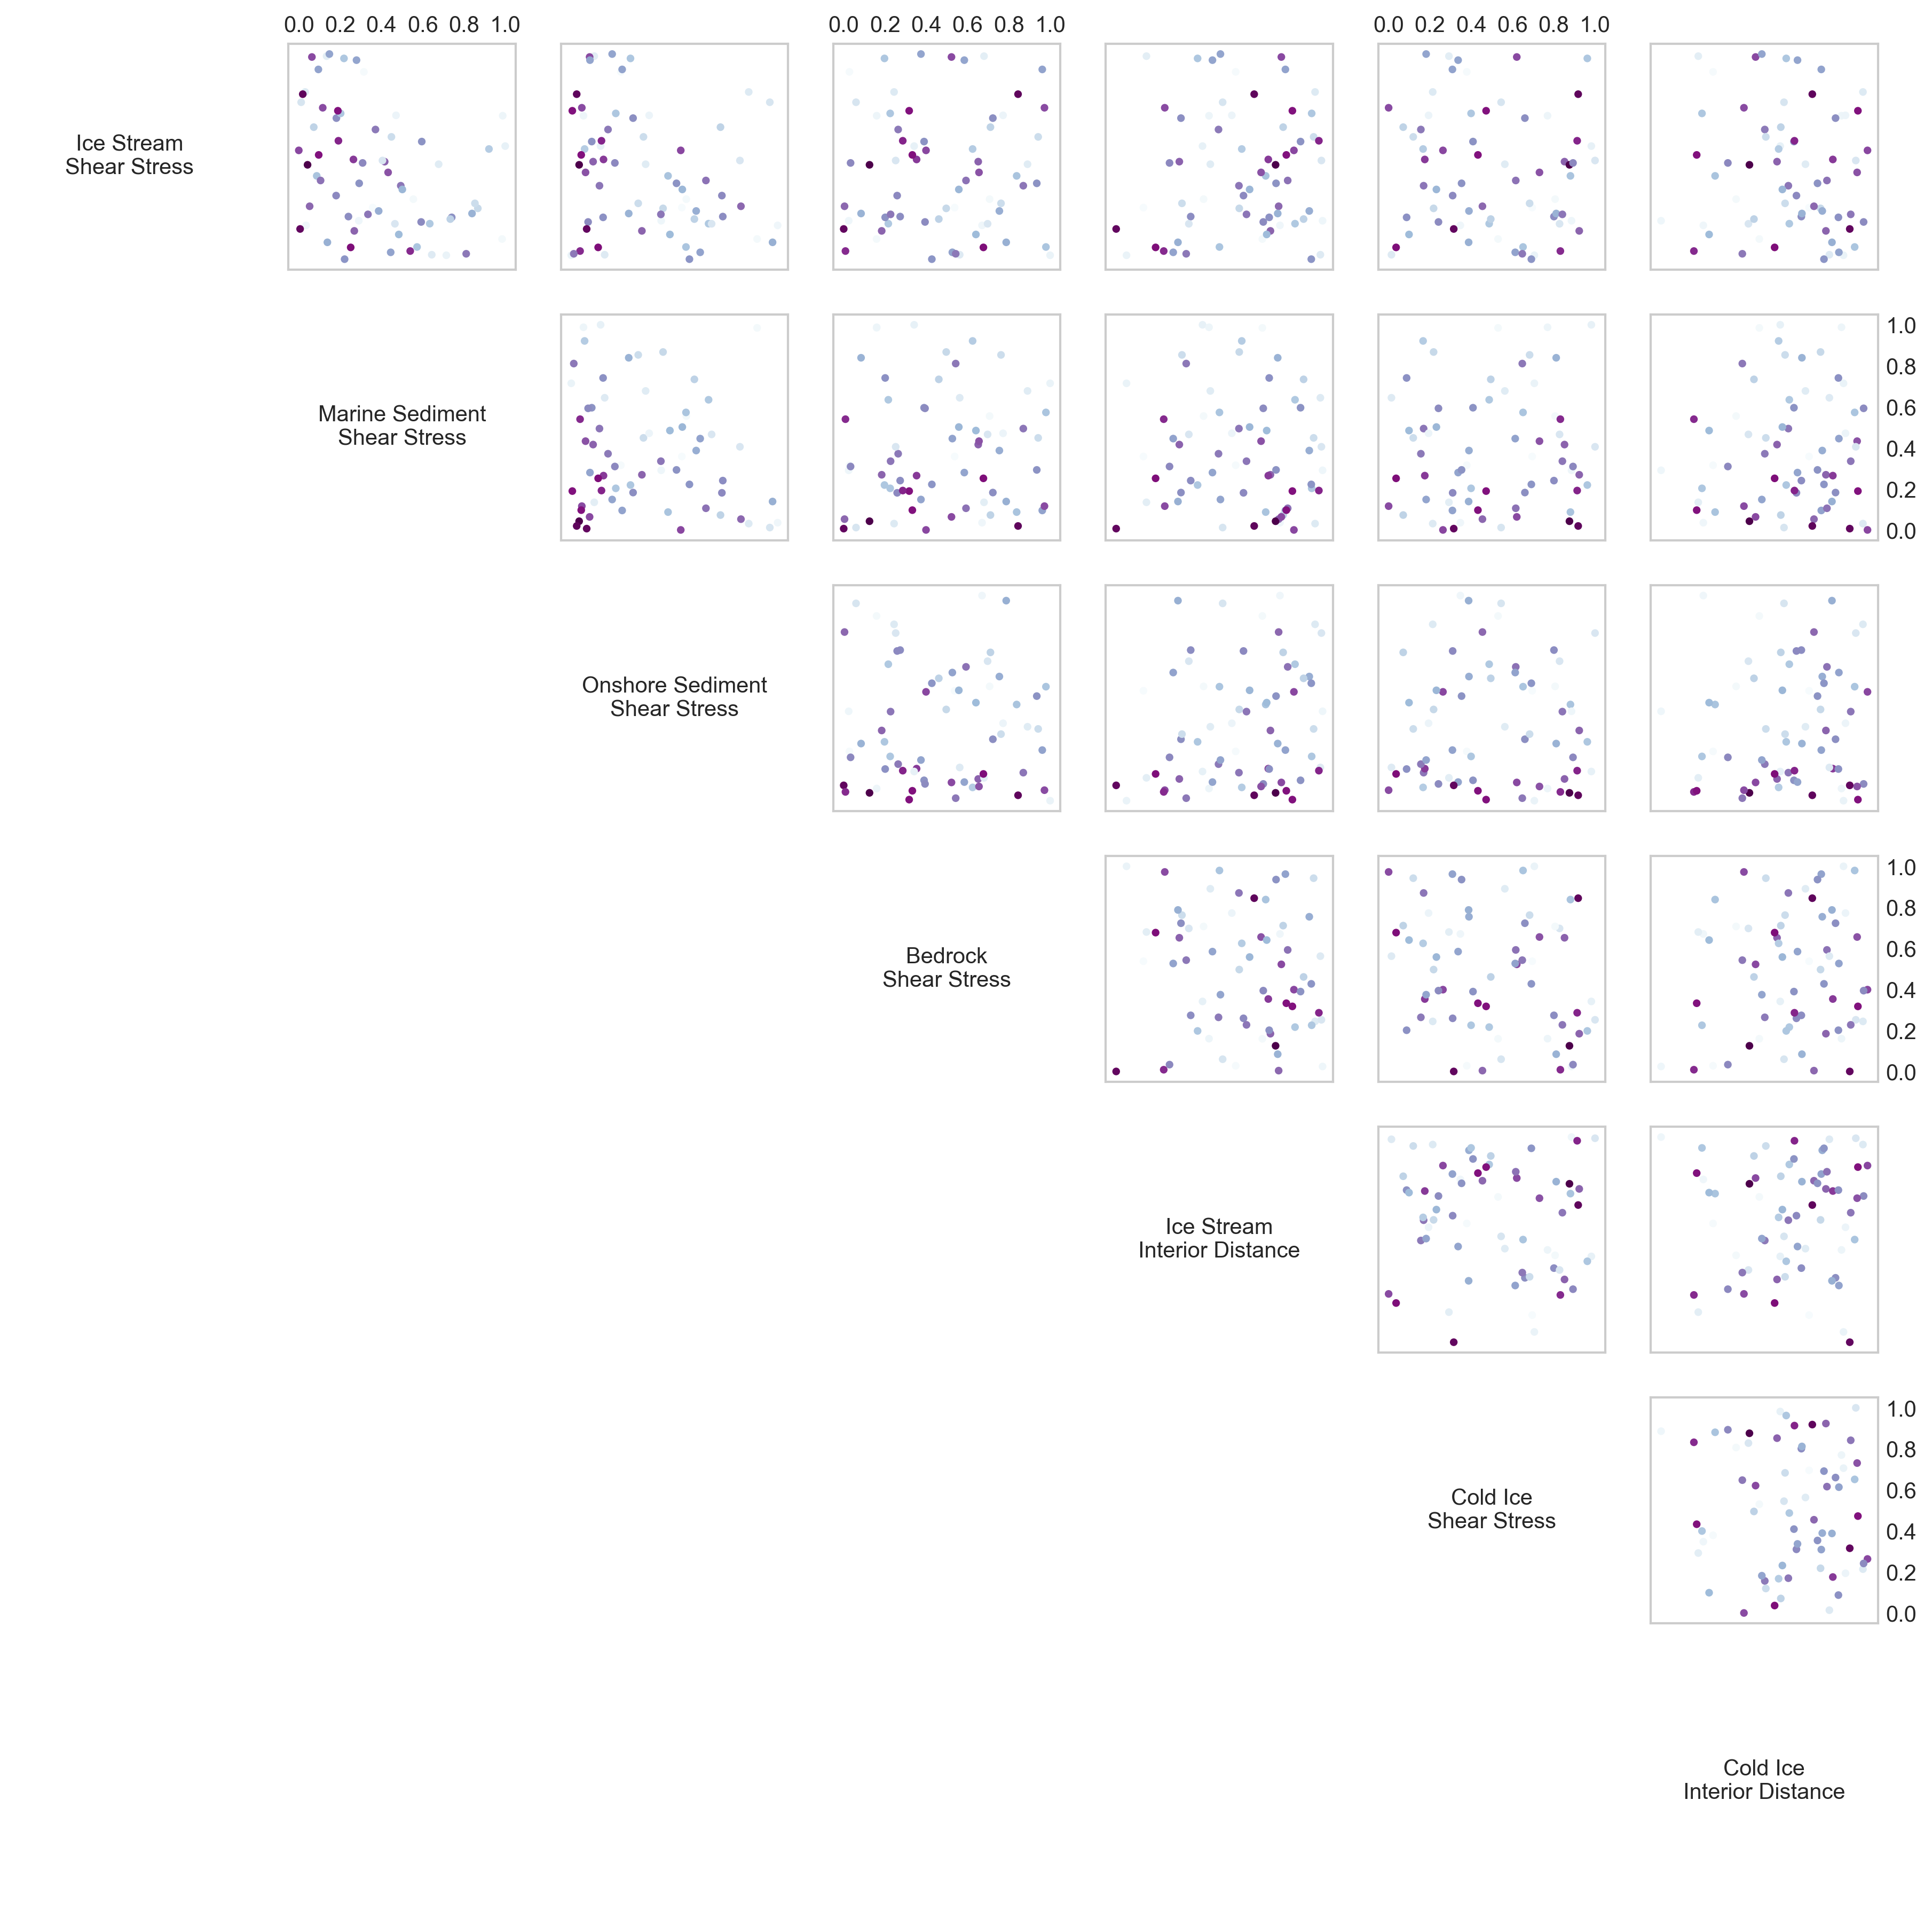

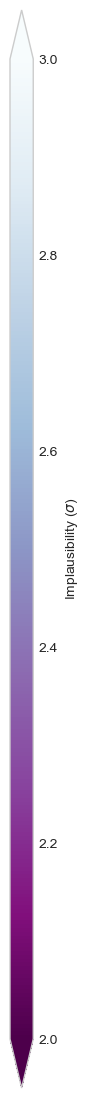

In [43]:
ld_param_names = [
    "Ice Stream\nShear Stress",
    "Marine Sediment\nShear Stress",
    "Onshore Sediment\nShear Stress",
    "Bedrock\nShear Stress",
    "Ice Stream\nInterior Distance",
    "Cold Ice\nShear Stress",
    "Cold Ice\nInterior Distance",
    
]

ranges = [
    [5000,20000],
    [10000,30000],
    [30000,100000],
    [100000,150000],
    [0,1000],
    [120000,200000],
    [300, 1000],
]

units = ["kPa", "kPa", "kPa", "kPa", "$10^{3}$ km", "kPa", "$10^{3}$ km"]


import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[14,4])
gs = gridspec.GridSpec(2, 8, hspace=0.5, wspace=0.2)
#gs.update(wspace=0.5)
ax = []
ax.append(fig.add_subplot(gs[0, 0:2]))
ax.append(fig.add_subplot(gs[0, 2:4]))
ax.append(fig.add_subplot(gs[0, 4:6]))
ax.append(fig.add_subplot(gs[0, 6:8]))
ax.append(fig.add_subplot(gs[1, 1:3]))
ax.append(fig.add_subplot(gs[1, 3:5]))
ax.append(fig.add_subplot(gs[1, 5:7]))
for index in range(7):
    ax[index].hist(
        ld_param_vals[:,index][ld_imp<=3]/1000, 
        range=np.array(ranges[index])/1000,
        color=(105/255, 28/255, 106/255,0.5),
        edgecolor=(105/255, 28/255, 106/255),
        histtype='stepfilled',
        lw=2
    )
    ax[index].set_xlabel(ld_param_names[index].replace("\n", " ") + " (" + units[index] + ')')
    ax[index].set_ylim(0,17)
    ax[index].set_xlim(np.array(ranges[index])/1000)
    if (index != 0) and (index != 4):
        ax[index].yaxis.set_ticklabels([])
    else:
        ax[index].set_ylabel("Frequency")
fig.savefig(f"../plots/f6_ld_imp/f6_ld_imp_a.png", dpi=300, bbox_inches="tight")

fig, ax, img = param_plot(
    ld_param_names, 
    ld_param_vals[ld_imp<=3], 
    data=ld_imp.flatten()[ld_imp<=3], 
    plot_kwargs={"cmap": "BuPu_r", "vmin": 2, "vmax":3}
)

fig.savefig("../plots/f6_ld_imp/f6_ld_imp_b.png", dpi=300, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(2,3,num=6), 
    label="Implausibility ($\sigma$)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/f6_ld_imp/f6_ld_imp_1.png", dpi=300, bbox_inches="tight")


In [44]:
plot_ext = "../plots/f6_ld_imp/f6_ld_imp_"

plot_width, plot_height = Image.open(f"{plot_ext}b.png").size
plot_a_width, plot_a_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size

"""
Layout
A1
"""
total_width = plot_width + cbar_width
total_height = plot_height + plot_a_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*(plot_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (int(total_width*0.5 - plot_a_width*0.5),0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (0,plot_a_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_width,plot_a_height+cbar_offset))

new_im.save('../plots/f6_ld_imp.png')

## Figure 7: Impact of ELRA Topography

In [118]:
#! mkdir paper1_plots/f7_elra_ice

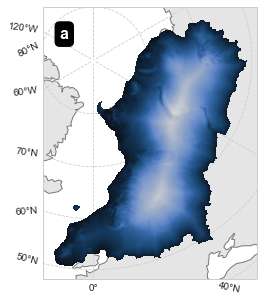

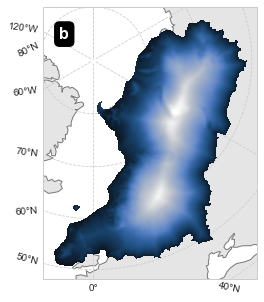

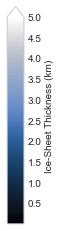

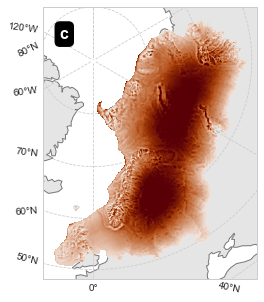

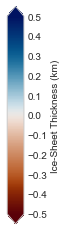

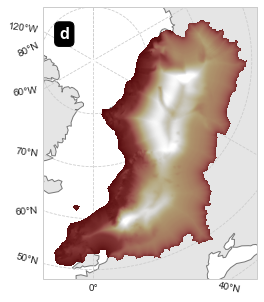

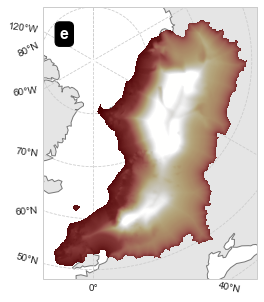

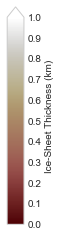

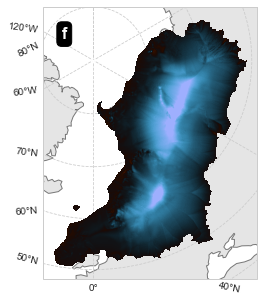

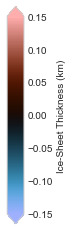

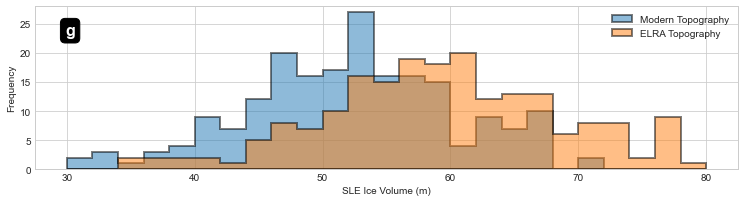

In [119]:
figname = "f7_elra_ice"

columns = [
    "Modern Topo",
    "ELRA",
    "Modern Topo - ELRA",
]
for index, column in enumerate(columns):
    fig, ax = plt.subplots(figsize=[4, .3])
    ax.text(
        0.5,
        0.5,
        s=column,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=0
    )
    ax.axis('off')
    fig.savefig(f"paper1_plots/{figname}/{figname}_tc{index+1}.png", dpi=300, bbox_inches="tight")
rows = [
    "Mean",
    "Std"
]
for index, row in enumerate(rows):
    fig, ax = plt.subplots(figsize=[.3,5])
    ax.text(
        0.5,
        0.5,
        s=row,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=90
    )
    ax.axis('off')
    fig.savefig(f"paper1_plots/{figname}/{figname}_tr{index+1}.png", dpi=300, bbox_inches="tight")
    
plot_array_dict = dict(
    a = batchelor_topo_0_ice_mean[0],
    b = batchelor_topo_1_ice_mean[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        cmap=cm.oslo
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    c = batchelor_topo_ice_mean_diff[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 0.5,
        vmin=-0.5,
        cmap=cm.vik_r
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-0.5,0.5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_2.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    d = batchelor_topo_0_ice_std[0],
    e = batchelor_topo_1_ice_std[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin = 0,
        cmap=cm.bilbao_r
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,1,num=11),
    label="Ice-Sheet Thickness (km)", 
    extend="max", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_3.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    f = batchelor_topo_ice_std_diff[0]
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 0.15,
        vmin=-0.15,
        cmap=cm.berlin
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-0.15,0.15,num=7), 
    label="Ice-Sheet Thickness (km)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_4.png", dpi=300, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[2*.3 + 3* 4,3])
text(ax, "g", x=0.05, y=0.85, fontsize=16)
ax.hist(batchelor_topo_0_ds.ice_volume_sle.values.flatten(), histtype= "stepfilled",alpha= 0.5, linewidth = 2, edgecolor="black", bins=np.arange(30, 80+1, 2), label="Modern Topography")
ax.hist(batchelor_topo_1_ds.ice_volume_sle.values.flatten(), histtype= "stepfilled",alpha= 0.5, linewidth = 2, edgecolor="black", label="ELRA Topography", bins=np.arange(30, 80+1, 2))
ax.set_xlabel("SLE Ice Volume (m)")
ax.set_ylabel("Frequency")
ax.set_ylim(0,28)
ax.legend(loc="upper right")
fig.savefig(f"paper1_plots/{figname}/{figname}_g.png", dpi=300, bbox_inches="tight")


In [120]:
plot_ext = f"paper1_plots/{figname}/{figname}_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size
hist_width, hist_height = Image.open(f"{plot_ext}g.png").size
trow_width, trow_height = Image.open(f"{plot_ext}tr1.png").size
tcol_width, tcol_height = Image.open(f"{plot_ext}tc1.png").size

"""
Layout
A1
"""
total_width = plot_width*3 + cbar_width*2 + trow_width+50
total_height = plot_height*2 + hist_height + tcol_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}tr1.png")
new_im.paste(im, (0,tcol_height))
im = Image.open(f"{plot_ext}tr2.png")
new_im.paste(im, (0,tcol_height+plot_height))

im = Image.open(f"{plot_ext}tc1.png")
new_im.paste(im, (trow_width*2,0))
im = Image.open(f"{plot_ext}tc2.png")
new_im.paste(im, (trow_width*2+plot_width,0))
im = Image.open(f"{plot_ext}tc3.png")
new_im.paste(im, (trow_width*2+plot_width*2+cbar_width,0))



cbar_offset = int(0.5*(plot_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (trow_width,tcol_height))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (trow_width+plot_width,tcol_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height))
im = Image.open(f"{plot_ext}2.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+cbar_offset))

im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (trow_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}e.png")
new_im.paste(im, (trow_width+plot_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}3.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+plot_height+cbar_offset))
im = Image.open(f"{plot_ext}f.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}4.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+plot_height+cbar_offset))

im = Image.open(f"{plot_ext}g.png")
new_im.paste(im, (int(0.5*(total_width) - 0.5*hist_width),tcol_height+plot_height*2))

new_im.save(f'paper1_plots/{figname}.png')

## Figure 8: Impact of History Matching

In [121]:
! mkdir paper1_plots/f8_pgm_ice

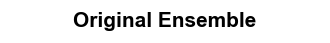

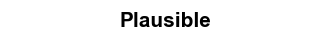

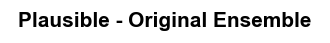

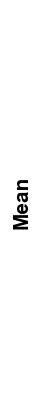

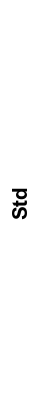

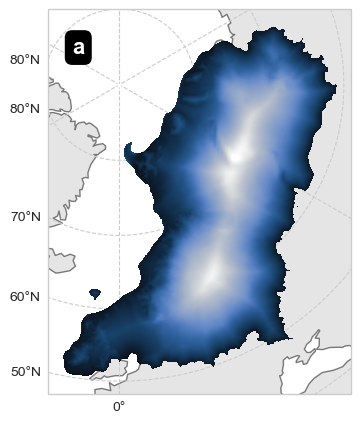

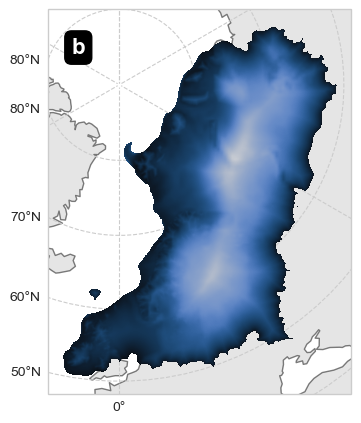

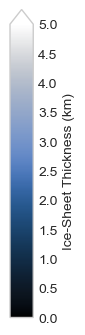

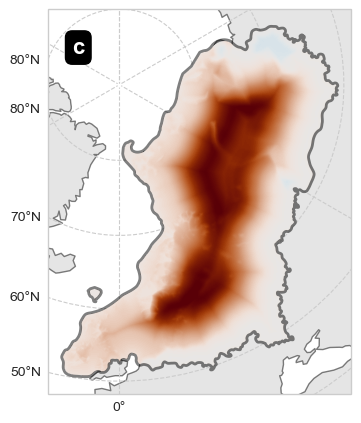

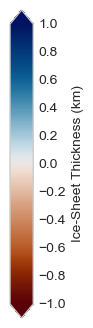

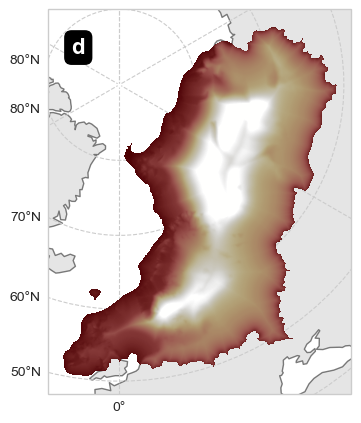

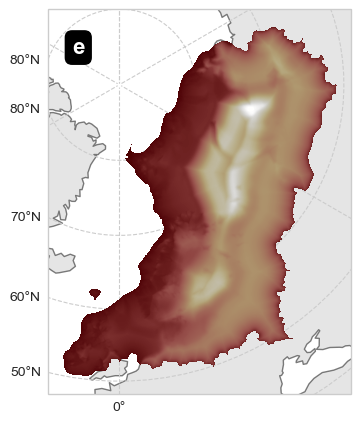

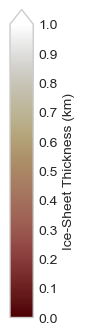

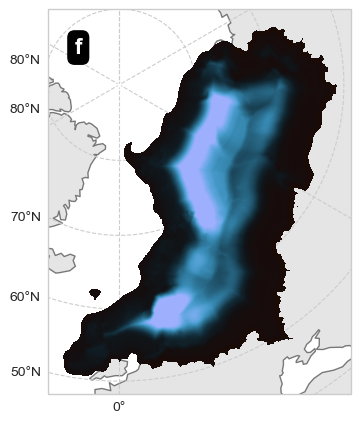

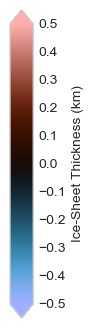

In [45]:
figname = "f8_pgm_ice"

columns = [
    "Original Ensemble",
    "Plausible",
    "Plausible - Original Ensemble",
]
for index, column in enumerate(columns):
    fig, ax = plt.subplots(figsize=[4, .3])
    ax.text(
        0.5,
        0.5,
        s=column,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=0
    )
    ax.axis('off')
    fig.savefig(f"../plots/{figname}/{figname}_tc{index+1}.png", dpi=300, bbox_inches="tight")
rows = [
    "Mean",
    "Std"
]
for index, row in enumerate(rows):
    fig, ax = plt.subplots(figsize=[.3,5])
    ax.text(
        0.5,
        0.5,
        s=row,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=90
    )
    ax.axis('off')
    fig.savefig(f"../plots/{figname}/{figname}_tr{index+1}.png", dpi=300, bbox_inches="tight")
    
plot_array_dict = dict(
    a = batchelor_icesheet_mean[0],
    b = batchelor_icesheet_nroy_mean[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        vmin=0,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    c = batchelor_icesheet_mean_diff[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin=-1,
        cmap=cm.vik_r
    )
    pgm_bf_gdf.plot(ax=ax,facecolor=(0,0,0,0), edgecolor=(0,0,0,0.5), linewidth=2, zorder=20)
    fig.savefig(f"../plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-1,1,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)

fig.savefig(f"../plots/{figname}/{figname}_2.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    d = batchelor_icesheet_std[0],
    e = batchelor_icesheet_nroy_std[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin = 0,
        cmap=cm.bilbao_r
    )
    fig.savefig(f"../plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,1,num=11),
    label="Ice-Sheet Thickness (km)", 
    extend="max", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/{figname}/{figname}_3.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    f = batchelor_icesheet_std_diff[0]
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 0.5,
        vmin=-0.5,
        cmap=cm.berlin
    )
    fig.savefig(f"../plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-0.5,0.5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/{figname}/{figname}_4.png", dpi=300, bbox_inches="tight")

In [46]:
plot_ext = f"../plots/{figname}/{figname}_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size
trow_width, trow_height = Image.open(f"{plot_ext}tr1.png").size
tcol_width, tcol_height = Image.open(f"{plot_ext}tc1.png").size

"""
Layout
A1
"""
total_width = plot_width*3 + cbar_width*2 + trow_width+50
total_height = plot_height*2 + tcol_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}tr1.png")
new_im.paste(im, (0,tcol_height))
im = Image.open(f"{plot_ext}tr2.png")
new_im.paste(im, (0,tcol_height+plot_height))

im = Image.open(f"{plot_ext}tc1.png")
new_im.paste(im, (trow_width*2,0))
im = Image.open(f"{plot_ext}tc2.png")
new_im.paste(im, (trow_width*2+plot_width,0))
im = Image.open(f"{plot_ext}tc3.png")
new_im.paste(im, (trow_width*2+plot_width*2+cbar_width,0))



cbar_offset = int(0.5*(plot_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (trow_width,tcol_height))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (trow_width+plot_width,tcol_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height))
im = Image.open(f"{plot_ext}2.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+cbar_offset))

im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (trow_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}e.png")
new_im.paste(im, (trow_width+plot_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}3.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+plot_height+cbar_offset))
im = Image.open(f"{plot_ext}f.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}4.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+plot_height+cbar_offset))

new_im.save(f'../plots/{figname}.png')

## Figure 9: Penultimate Glacial Maximum

In [247]:
# ! mkdir paper1_plots/f9_pgm_dist

In [49]:
batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[nroy_pgm].shape

(26, 1216, 1086)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


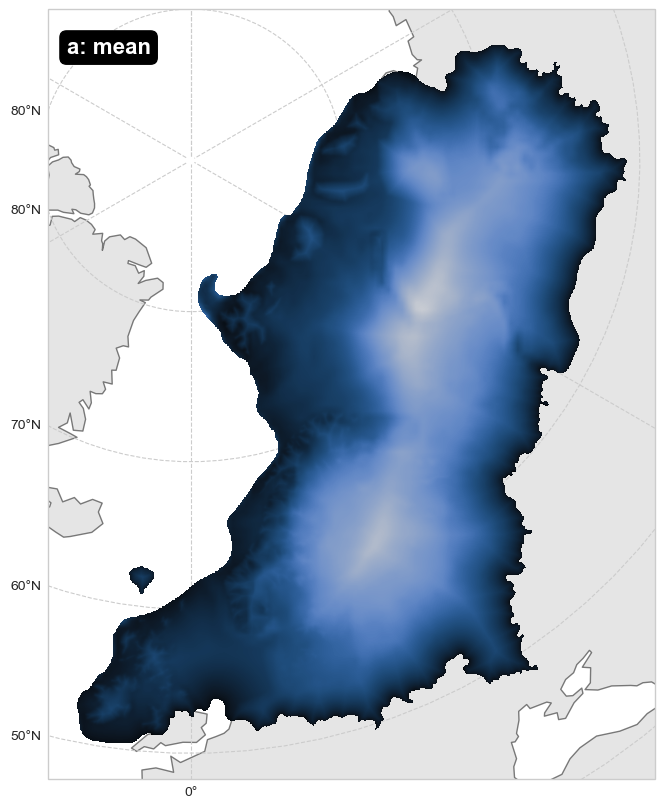

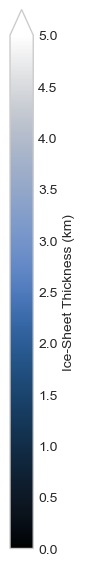

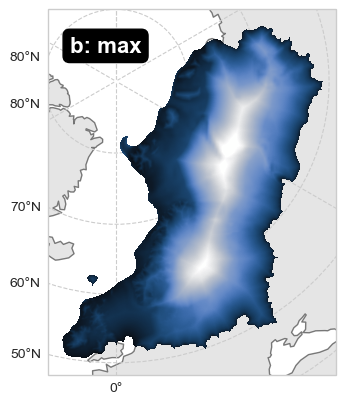

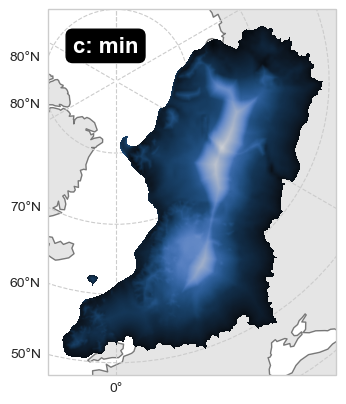

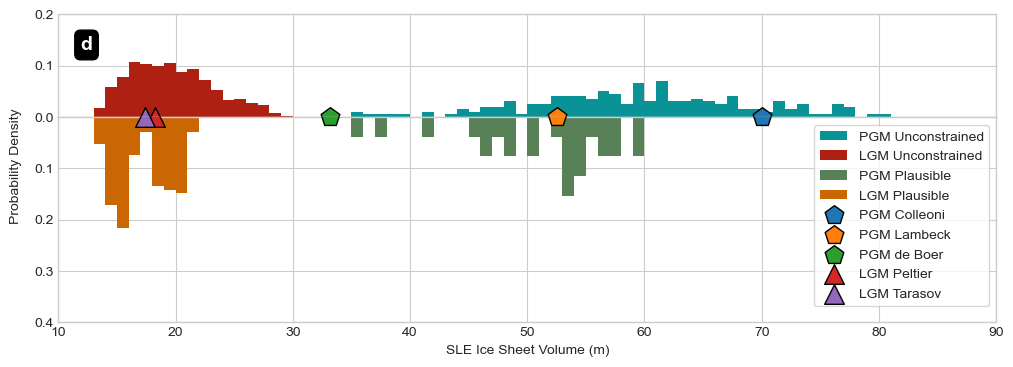

In [64]:
figname = "f9_pgm_dist"
plot_array_dict = {
    'a: mean': batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[nroy_pgm].mean(axis=0),
}
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4*2,5*2])
    text(ax, label, x=0.1, y=0.95, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        vmin=0,
        cmap=cm.oslo
    )
    fig.savefig(f"../plots/{figname}/{figname}_{label[0]}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,7])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"../plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

arg_max = np.arange(200)[nroy_pgm][pgm_vols[nroy_pgm].argmax()]
arg_min = np.arange(200)[nroy_pgm][pgm_vols[nroy_pgm].argmin()]
plot_array_dict = {
    'b: max': batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[arg_max],
    'c: min': batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[arg_min],
}
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=np.array([4,5])*0.95)
    text(ax, label, x=0.2, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        vmin=0,
        cmap=cm.oslo
    )
    
    fig.savefig(f"../plots/{figname}/{figname}_{label[0]}.png", dpi=300, bbox_inches="tight")
    
    
bins = np.arange(0,90, 1)
fig, ax = plt.subplots(2,1,figsize=[8+.3+0.95*4,4], gridspec_kw={'height_ratios': [0.5,1]})
ax[0].hist(volume_to_sle(batchelor_topo_1_analytics_ds.ice_volume.values.flatten()), bins=bins, density=True, color="#0a9396", label="PGM Unconstrained")
ax[1].hist(volume_to_sle(batchelor_topo_1_analytics_ds.ice_volume.values[nroy_pgm].flatten()), bins=bins, density=True,color="#588157", label="PGM Plausible")
ax[0].hist(
    np.concatenate([
        volume_to_sle(ice6g_icesheet_analytics_ds.sel(time=-22000).ice_volume.values.flatten()),
        volume_to_sle(glac1d_icesheet_analytics_ds.sel(time=-22000).ice_volume.values.flatten())
    ]), 
    bins=bins, density=True,color="#ae2012", label="LGM Unconstrained")
ax[1].hist(
    np.concatenate([
        volume_to_sle(ice6g_icesheet_analytics_ds.sel(time=-22000).ice_volume.values[nroy].flatten()),
        volume_to_sle(glac1d_icesheet_analytics_ds.sel(time=-22000).ice_volume.values[nroy].flatten())
    ]), 
     
    bins=bins, density=True,color="#ca6702", label="LGM Plausible")

ax[0].set_yticks([0.1,0.2])
ax[0].set_xticklabels([])
ax[0].set_ylim(0,0.2)
ax[1].set_ylim(0.4,0)
ax[0].set_xlim(10,90)
ax[1].set_xlim(10,90)

ax[1].set_xlabel("SLE Ice Sheet Volume (m)")

fig.text(0.085, 0.5, 'Probability Density', va='center', rotation='vertical')

plt.subplots_adjust(hspace=0)
    
for idx, axis in enumerate(ax):
    # colleoni
    axis.scatter(
        [70], 
        [0],
        color="C0",
        marker="p",
        s=200,
        label = "PGM Colleoni" if idx == 1 else None,
        edgecolors='black',
        zorder=20
    )
    # lambeck
    axis.scatter(
        [52.5], 
        [0],
        color="C1",
        marker="p",
        s=200,
        label = "PGM Lambeck" if idx == 1 else None,
        edgecolors='black',
        zorder=20
    )
    # de Boer
    axis.scatter(
        [33.2], 
        [0],
        color="C2",
        marker="p",
        s=200,
        label = "PGM de Boer" if idx == 1 else None,
        edgecolors='black',
        zorder=20
    )

    # peltier 22ka    
    axis.scatter(
        [18.22], 
        [0],
        color="C3",
        marker="^",
        s=200,
        label = "LGM Peltier" if idx == 1 else None,
        edgecolors='black',
        zorder=20
    )

    # tarasov 22ka   
    axis.scatter(
        [17.35], 
        [0],
        color="C4",
        marker="^",
        s=200,
        label = "LGM Tarasov" if idx == 1 else None,
        edgecolors='black',
        zorder=20
    )
    legend_data = [
        axis.collections[0],
        axis.collections[1],
        axis.collections[2],
        axis.collections[3],
        axis.collections[-5],
        axis.collections[-4],
        axis.collections[-3],
        axis.collections[-2],
        axis.collections[-1],
    ]
fig.legend(
    #loc='upper right', 
    bbox_to_anchor=(0.9, 0.62),
    frameon=True
)



text(ax[0], text="d", x=0.03,y=0.7)

fig.savefig(f"../plots/{figname}/{figname}_d.png", dpi=300, bbox_inches="tight")



In [65]:
plot_ext = f"../plots/{figname}/{figname}_"

plot_a_width, plot_a_height = Image.open(f"{plot_ext}a.png").size
plot_b_width, plot_b_height = Image.open(f"{plot_ext}b.png").size
plot_d_width, plot_d_height = Image.open(f"{plot_ext}d.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size

"""
Layout
A1
"""
total_width = plot_a_width + plot_b_width + cbar_width
total_height = plot_a_height + plot_d_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*(plot_a_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_a_width,0))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (plot_a_width,plot_b_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_a_width+plot_b_width,cbar_offset))
im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (-10,plot_a_height))

new_im.save(f'../plots/{figname}.png')

In [61]:
! ls ../plots/f9_pgm_dist

f9_pgm_dist_1.pdf	 f9_pgm_dist_b: max.pdf  f9_pgm_dist_c.png
f9_pgm_dist_1.png	 f9_pgm_dist_b: max.png  f9_pgm_dist_d.pdf
f9_pgm_dist_a: mean.pdf  f9_pgm_dist_b.png	 f9_pgm_dist_d.png
f9_pgm_dist_a: mean.png  f9_pgm_dist_c: min.pdf
f9_pgm_dist_a.png	 f9_pgm_dist_c: min.png


## Figure 9: Penultimate Glacial Maximum (alt)

In [250]:
#! mkdir paper1_plots/f9_pgm_dist_alt

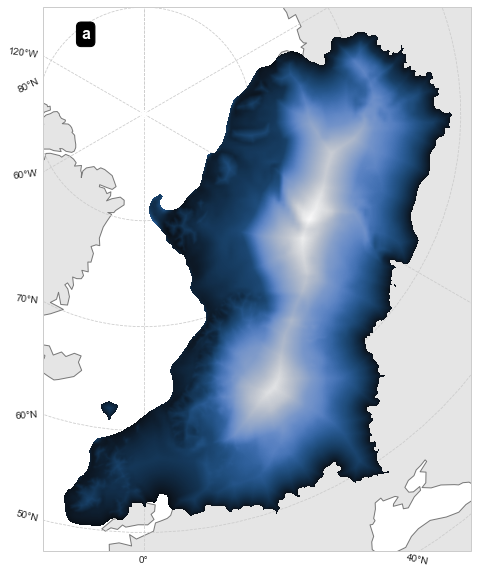

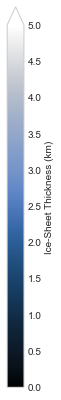

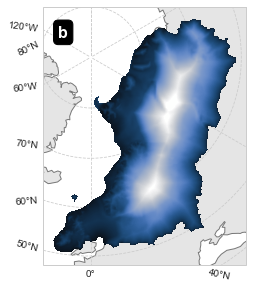

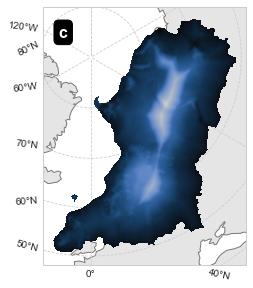

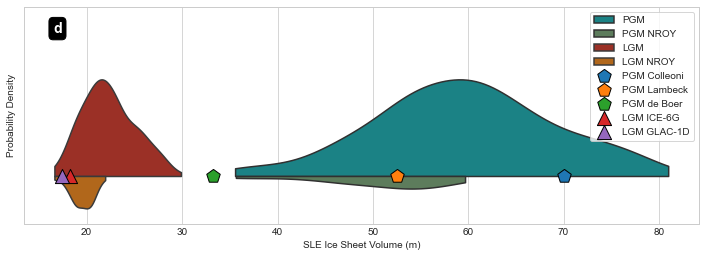

In [301]:
figname = "f9_pgm_dist_alt"
plot_array_dict = dict(
    a = batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[nroy_pgm][24],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4*2,5*2])
    text(ax, label, x=0.1, y=0.95, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        vmin=0,
        cmap=cm.oslo
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,7])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,5,num=11), 
    label="Ice-Sheet Thickness (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

arg_max = np.arange(200)[nroy_pgm][pgm_vols[nroy_pgm].argmax()]
arg_min = np.arange(200)[nroy_pgm][pgm_vols[nroy_pgm].argmin()]
plot_array_dict = dict(
    b = batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[arg_max],
    c = batchelor_icesheet_ds.ice_thickness.sel(time=-140000).values[arg_min],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=np.array([4,5])*0.95)
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=1, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 5,
        vmin=0,
        cmap=cm.oslo
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")
    
    


fig, ax = plt.subplots(figsize=[8+.3+0.95*4,4])
for idx, ds in enumerate([batchelor_topo_1_analytics_ds, ice6g_icesheet_analytics_ds]):

    if idx == 0:
        times = np.concatenate(
            [
                np.ones((200))*-140, 
                np.ones((np.sum(nroy_pgm)))*-140
            ]
        )
        volumes = np.concatenate(
            [
                ds.ice_volume.values.flatten(), 
                ds.ice_volume.values[nroy_pgm].flatten()
            ]
        )
        hist_matched = [False for index in range(200)] + [True for index in range(np.sum(nroy_pgm))]
    else:
        times = np.concatenate(
            [
                np.ones((200))*-140, 
                np.ones((np.sum(nroy)))*-140
            ]
        )
        volumes = np.concatenate(
            [
                ds.ice_volume.sel(time=-22000).values.flatten(), 
                ds.ice_volume.sel(time=-22000).values[nroy].flatten()
            ]
        )
        hist_matched = [False for index in range(200)] + [True for index in range(np.sum(nroy))]
    volumes = volume_to_sle(volumes)

    
    data = {
        'Time': times, 
        'Ice Sheet Volume': volumes,
        'History Matched': hist_matched

    }
    df = pd.DataFrame(data = data)
    df['y'] = ""

    sns.violinplot(
        ax = ax,
        x = "Ice Sheet Volume",
        y='y',
        hue="History Matched",
        data=df,
        split=True,
        scale = "count",
        inner=None,
        palette = palettes[idx],
        cut=0,
        #gridsize=10000,
    )

    

# colleoni
ax.scatter(
    [70], 
    [0],
    marker="p",
    s=200,
    edgecolors='black',
    zorder=20
)
# lambeck
ax.scatter(
    [52.5], 
    [0],
    marker="p",
    s=200,
    edgecolors='black',
    zorder=20
)
# de Boer
ax.scatter(
    [33.2], 
    [0],
    marker="p",
    s=200,
    edgecolors='black',
    zorder=20
)

# peltier 22ka    
ax.scatter(
    [18.22], 
    [0],
    marker="^",
    s=200,
    edgecolors='black',
    zorder=20
)

# tarasov 22ka   
ax.scatter(
    [17.35], 
    [0],
    marker="^",
    s=200,
    edgecolors='black',
    zorder=20
)

legend_data = [
    ax.collections[0],
    ax.collections[1],
    ax.collections[2],
    ax.collections[3],
    ax.collections[-5],
    ax.collections[-4],
    ax.collections[-3],
    ax.collections[-2],
    ax.collections[-1],
]
ax.legend(
    handles=legend_data, 
    loc='upper right', 
    labels=[
        "PGM", 
        "PGM NROY", 
        "LGM", 
        "LGM NROY",
        "PGM Colleoni",
        "PGM Lambeck",
        "PGM de Boer",
        "LGM ICE-6G",
        "LGM GLAC-1D",
    ],
    frameon=True
)


ax.set_ylabel("Probability Density")
ax.set_xlabel("SLE Ice Sheet Volume (m)")

ax.set_ylim(0.2,-0.7)

text(ax, text="d", x=0.05,y=0.9)

fig.savefig(f"paper1_plots/{figname}/{figname}_d.png", dpi=300, bbox_inches="tight")

In [302]:
plot_ext = f"paper1_plots/{figname}/{figname}_"

plot_a_width, plot_a_height = Image.open(f"{plot_ext}a.png").size
plot_b_width, plot_b_height = Image.open(f"{plot_ext}b.png").size
plot_d_width, plot_d_height = Image.open(f"{plot_ext}d.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size

"""
Layout
A1
"""
total_width = plot_a_width + plot_b_width + cbar_width
total_height = plot_a_height + plot_d_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*(plot_a_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_a_width,0))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (plot_a_width,plot_b_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_a_width+plot_b_width,cbar_offset))
im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (-10,plot_a_height))

new_im.save(f'paper1_plots/{figname}.png')

# Supporting Figures

## Figure S1: Last Deglaciation Margins

In [306]:
! mkdir paper1_plots/fs1_ld_margins

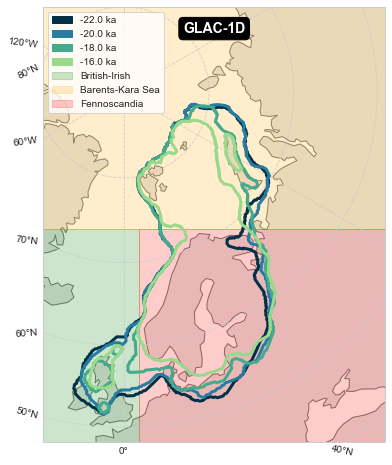

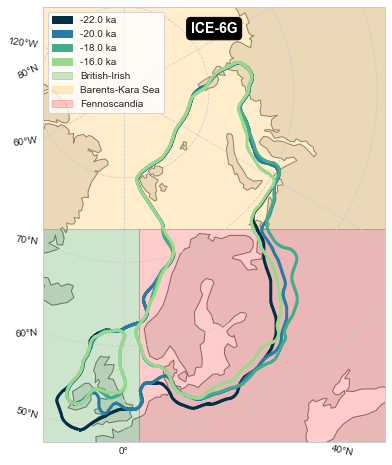

In [307]:
figname = "fs1_ld_margins"

times = [-22000,-20000,-18000,-16000]
margin_colors = ["#023047", "#277da1", "#43aa8b", "#99d98c"]
fig, ax = plot_map(text="GLAC-1D")
legend = []
for t_index, time in enumerate(times):
    margin_gdf = gpd.read_file(f"/nfs/annie/cm15ogp/phd/data/ice_margins/glac1d/smooth_v1_topoclip_mod_-1km/{str(time)}/margin.shp").to_crs(crs)
    margin_gdf.plot(
        ax=ax, 
        zorder=10, 
        facecolor=(0,0,0,0), 
        ec=margin_colors[t_index], 
        lw=3
    )
    legend.append(mpatches.Patch(color=margin_colors[t_index], label=f'{time/1000} ka'))
    
legend.append(mpatches.Patch(color="green", alpha=0.2,label=f'British-Irish'))
legend.append(mpatches.Patch(color="orange", alpha=0.2,label=f'Barents-Kara Sea'))
legend.append(mpatches.Patch(color="red", alpha=0.2,label=f'Fennoscandia'))

ax.legend(handles=legend, loc="upper left", fontsize=10, frameon=True)

geom = Polygon(
    [
        [x[0], y[588]],
        [x[0], y[0]],
        [x[294], y[0]],
        [x[294], y[588]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="green")

geom = Polygon(
    [
        [x[0], y[-1]],
        [x[0], y[588]],
        [x[-1], y[588]],
        [x[-1], y[-1]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="orange")
geom = Polygon(
    [
        [x[294], y[588]],
        [x[294], y[0]],
        [x[-1], y[0]],
        [x[-1], y[588]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="red")

fig.savefig(f"paper1_plots/{figname}/{figname}_a.png", dpi=300, bbox_inches="tight")


times = [-22000,-20000,-18000,-16000]
margin_colors = ["#023047", "#277da1", "#43aa8b", "#99d98c"]
fig, ax = plot_map(text="ICE-6G")
legend = []
for t_index, time in enumerate(times):
    margin_gdf = gpd.read_file(f"/nfs/annie/cm15ogp/phd/data/ice_margins/ice6g/smooth_v2_topoclip_mod_-1km/{str(time)}/margin.shp").to_crs(crs)
    margin_gdf.plot(
        ax=ax, 
        zorder=10, 
        facecolor=(0,0,0,0), 
        ec=margin_colors[t_index], 
        lw=3
    )
    legend.append(mpatches.Patch(color=margin_colors[t_index], label=f'{time/1000} ka'))
legend.append(mpatches.Patch(color="green", alpha=0.2,label=f'British-Irish'))
legend.append(mpatches.Patch(color="orange", alpha=0.2,label=f'Barents-Kara Sea'))
legend.append(mpatches.Patch(color="red", alpha=0.2,label=f'Fennoscandia'))

ax.legend(handles=legend, loc="upper left", fontsize=10, frameon=True)

geom = Polygon(
    [
        [x[0], y[588]],
        [x[0], y[0]],
        [x[294], y[0]],
        [x[294], y[588]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="green")

geom = Polygon(
    [
        [x[0], y[-1]],
        [x[0], y[588]],
        [x[-1], y[588]],
        [x[-1], y[-1]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="orange")
geom = Polygon(
    [
        [x[294], y[588]],
        [x[294], y[0]],
        [x[-1], y[0]],
        [x[-1], y[588]],
    ]
)
ax.add_geometries([geom], crs=plot_crs, alpha=0.2, color="red")
fig.savefig(f"paper1_plots/{figname}/{figname}_b.png", dpi=300, bbox_inches="tight")



In [308]:
plot_ext = f"paper1_plots/{figname}/{figname}_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size

total_width = plot_width*2
total_height = plot_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_width,0))

new_im.save(f'paper1_plots/{figname}.png')

## Figure S3: ELRA Topography

In [309]:
! mkdir paper1_plots/fs3_elra_topo

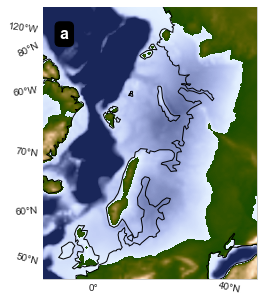

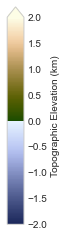

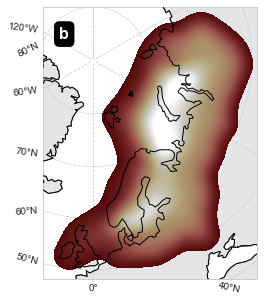

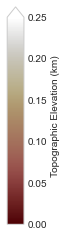

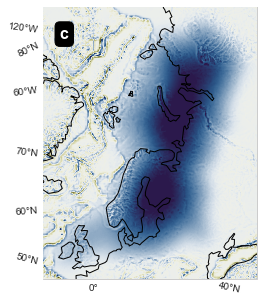

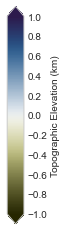

In [311]:
figname = "fs3_elra_topo"

columns = [
    "ELRA Mean",
    "ELRA Std",
    "Modern Topo - ELRA Mean",
]
for index, column in enumerate(columns):
    fig, ax = plt.subplots(figsize=[4, .3])
    ax.text(
        0.5,
        0.5,
        s=column,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=0
    )
    ax.axis('off')
    fig.savefig(f"paper1_plots/{figname}/{figname}_tc{index+1}.png", dpi=300, bbox_inches="tight")
    
plot_array_dict = dict(
    a = batchelor_topo_1_topo_mean,
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    ax.coastlines(zorder=20)
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        plot_array/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmin=-2,
        vmax=2,
        cmap=cm.oleron
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-2,2,num=9), 
    label="Topographic Elevation (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    b = batchelor_topo_1_topo_std,
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    ax.coastlines(zorder=20)
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=5, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmin=0,
        vmax=0.25,
        cmap=cm.bilbao_r
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,0.25,num=6), 
    label="Topographic Elevation (km)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_2.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    c = batchelor_topo_topo_diff,
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    ax.coastlines(zorder=20)
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 1,
        vmin=-1,
        cmap=cm.broc_r
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-1,1,num=11), 
    label="Topographic Elevation (km)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_3.png", dpi=300, bbox_inches="tight")



In [312]:
plot_ext = f"paper1_plots/{figname}/{figname}_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size
tcol_width, tcol_height = Image.open(f"{plot_ext}tc1.png").size

total_width = plot_width*3 + cbar_width*3
total_height = plot_height + tcol_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*plot_height - 0.5*cbar_height)

im = Image.open(f"{plot_ext}tc1.png")
new_im.paste(im, (100,0))
im = Image.open(f"{plot_ext}tc2.png")
new_im.paste(im, (100+plot_width+cbar_width,0))
im = Image.open(f"{plot_ext}tc3.png")
new_im.paste(im, (100+plot_width*2+cbar_width*2,0))

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,tcol_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_width,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (plot_width+cbar_width,tcol_height))
im = Image.open(f"{plot_ext}2.png")
new_im.paste(im, (plot_width*2+cbar_width,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (plot_width*2+cbar_width*2,tcol_height))
im = Image.open(f"{plot_ext}3.png")
new_im.paste(im, (plot_width*3+cbar_width*2,tcol_height+cbar_offset))

new_im.save(f'paper1_plots/{figname}.png')

## Figure S4: PGM Shear Stress Maps

In [315]:
batchelor_icesheet_ds = xr.open_dataset("paper1_data/icesheet_runs/batchelor/batchelor_topo_1.nc")
hist_match_ds = xr.open_dataset("history_match_pgm.nc")
nroy_pgm = hist_match_ds.nroy.values

batchelor_shearstress_mean = batchelor_icesheet_ds.basal_shearstress.sel(time=[-140000]).values.mean(axis=0)
batchelor_shearstress_std = batchelor_icesheet_ds.basal_shearstress.sel(time=[-140000]).values.std(axis=0)

batchelor_shearstress_nroy_mean = batchelor_icesheet_ds.basal_shearstress.sel(time=[-140000])[nroy_pgm].values.mean(axis=0)
batchelor_shearstress_nroy_std = batchelor_icesheet_ds.basal_shearstress.sel(time=[-140000])[nroy_pgm].values.std(axis=0)

batchelor_shearstress_mean_diff = batchelor_shearstress_nroy_mean - batchelor_shearstress_mean
batchelor_shearstress_std_diff = batchelor_shearstress_nroy_std - batchelor_shearstress_std

In [316]:
#! mkdir paper1_plots/fs4_pgm_shearstress

mkdir: cannot create directory ‘paper1_plots/fs4_pgm_shearstress’: File exists


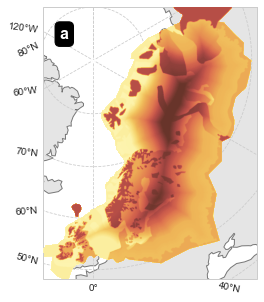

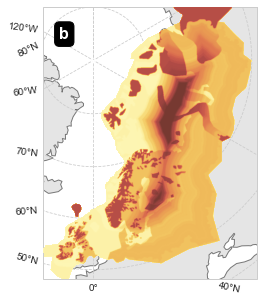

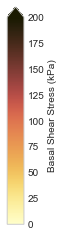

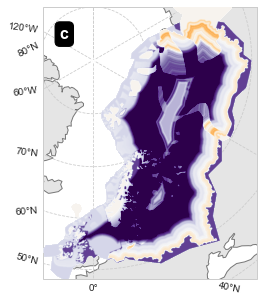

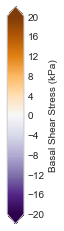

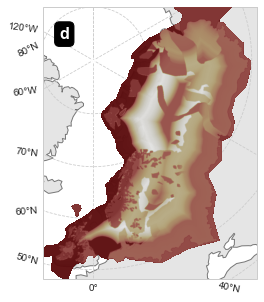

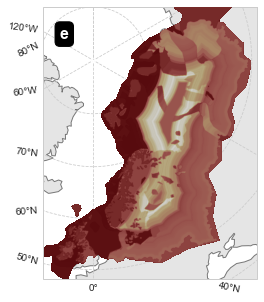

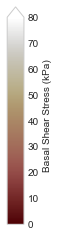

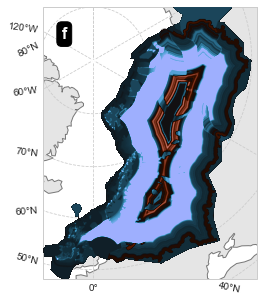

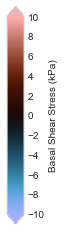

In [317]:
figname = "fs4_pgm_shearstress"
columns = [
    "Original Ensemble",
    "NROY",
    "NROY - Original Ensemble",
]
for index, column in enumerate(columns):
    fig, ax = plt.subplots(figsize=[4, .3])
    ax.text(
        0.5,
        0.5,
        s=column,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=0
    )
    ax.axis('off')
    fig.savefig(f"paper1_plots/{figname}/{figname}_tc{index+1}.png", dpi=300, bbox_inches="tight")
    
    
rows = [
    "Mean",
    "Std"
]
for index, row in enumerate(rows):
    fig, ax = plt.subplots(figsize=[.3,5])
    ax.text(
        0.5,
        0.5,
        s=row,
        ha='center',
        va='center', 
        transform=ax.transAxes, 
        fontweight='bold', 
        fontsize=15, 
        color="black", 
        #bbox=dict(boxstyle='round', facecolor='black'), 
        zorder=20,
        rotation=90
    )
    ax.axis('off')
    fig.savefig(f"paper1_plots/{figname}/{figname}_tr{index+1}.png", dpi=300, bbox_inches="tight")
    
plot_array_dict = dict(
    a = batchelor_shearstress_mean[0],
    b = batchelor_shearstress_nroy_mean[0]
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array<=5000, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmin=0,
        vmax=200,
        cmap=cm.lajolla
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,200,num=9), 
    label="Basal Shear Stress (kPa)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_1.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    c = batchelor_shearstress_mean_diff[0],
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 20,
        vmin=-20,
        cmap="PuOr_r"
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")
    

fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-20,20,num=11), 
    label="Basal Shear Stress (kPa)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_2.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    d = batchelor_shearstress_std[0],
    e = batchelor_shearstress_nroy_std[0]
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
    np.ma.masked_where(plot_array<=1, plot_array)/1000,
    extent=extent,
    origin="lower",
    zorder=10,
    vmin=0,
    vmax=80,
    cmap=cm.bilbao_r
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(0,80,num=9), 
    label="Basal Shear Stress (kPa)", 
    extend="max",
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_3.png", dpi=300, bbox_inches="tight")

plot_array_dict = dict(
    f = batchelor_shearstress_std_diff[0]
)
for label, plot_array in plot_array_dict.items():
    fig, ax = plot_map(figsize=[4,5])
    text(ax, label, x=0.1, y=0.9, fontsize=16)
    img = ax.imshow(
        np.ma.masked_where(plot_array==0, plot_array)/1000,
        extent=extent,
        origin="lower",
        zorder=10,
        vmax = 10,
        vmin=-10,
        cmap=cm.berlin
    )
    fig.savefig(f"paper1_plots/{figname}/{figname}_{label}.png", dpi=300, bbox_inches="tight")


fig, ax = plt.subplots(figsize=[.3,4])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(-10,10,num=11), 
    label="Basal Shear Stress (kPa)", 
    extend="both", 
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/{figname}/{figname}_4.png", dpi=300, bbox_inches="tight")


In [318]:
plot_ext = f"paper1_plots/{figname}/{figname}_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size
trow_width, trow_height = Image.open(f"{plot_ext}tr1.png").size
tcol_width, tcol_height = Image.open(f"{plot_ext}tc1.png").size

"""
Layout
A1
"""
total_width = plot_width*3 + cbar_width*2 + trow_width+50
total_height = plot_height*2 + tcol_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}tr1.png")
new_im.paste(im, (0,tcol_height))
im = Image.open(f"{plot_ext}tr2.png")
new_im.paste(im, (0,tcol_height+plot_height))

im = Image.open(f"{plot_ext}tc1.png")
new_im.paste(im, (trow_width*2,0))
im = Image.open(f"{plot_ext}tc2.png")
new_im.paste(im, (trow_width*2+plot_width,0))
im = Image.open(f"{plot_ext}tc3.png")
new_im.paste(im, (trow_width*2+plot_width*2+cbar_width,0))



cbar_offset = int(0.5*(plot_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (trow_width,tcol_height))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (trow_width+plot_width,tcol_height))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+cbar_offset))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height))
im = Image.open(f"{plot_ext}2.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+cbar_offset))

im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (trow_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}e.png")
new_im.paste(im, (trow_width+plot_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}3.png")
new_im.paste(im, (trow_width+plot_width*2,tcol_height+plot_height+cbar_offset))
im = Image.open(f"{plot_ext}f.png")
new_im.paste(im, (trow_width+plot_width*2+cbar_width,tcol_height+plot_height))
im = Image.open(f"{plot_ext}4.png")
new_im.paste(im, (trow_width+plot_width*3+cbar_width,tcol_height+plot_height+cbar_offset))

new_im.save(f'paper1_plots/{figname}.png')

# LGM Outputs

In [372]:
ld_imp_time.mean(axis=0)

array([3.26670817, 5.16716579, 2.66687919, 3.13003573])

mkdir: cannot create directory `paper1_plots/ld_imp_time/': File exists


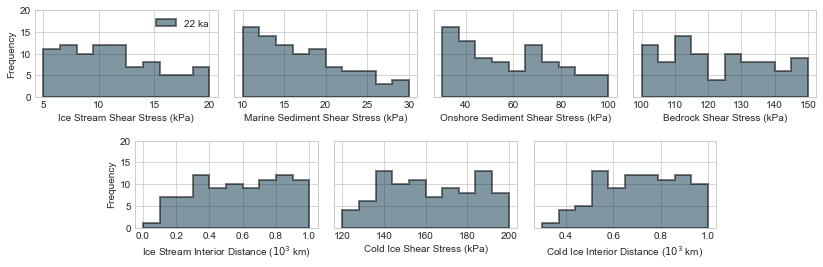

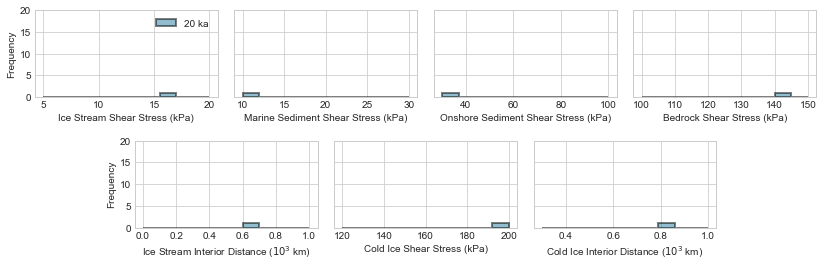

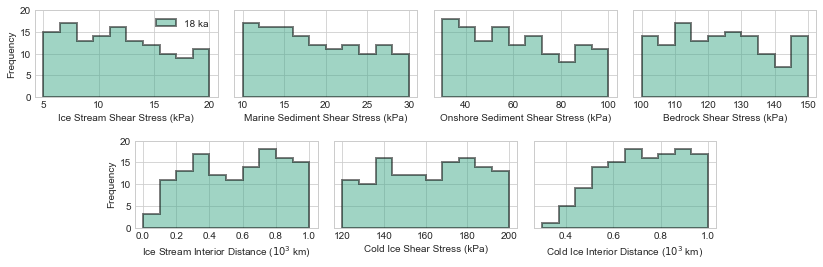

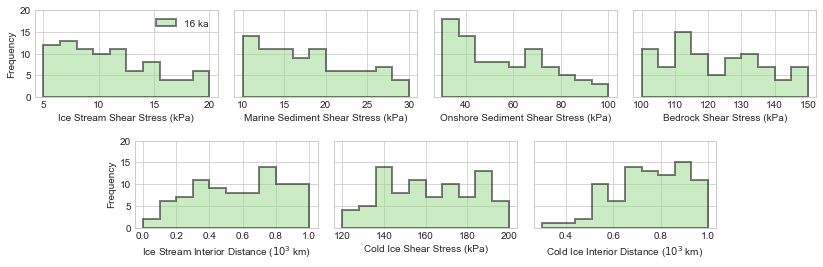

In [379]:
chars = ["a", "b", "c", "d"]
for t_idx in range(4):
    fig = plt.figure(figsize=[14,4])
    gs = gridspec.GridSpec(2, 8, hspace=0.5, wspace=0.2)
    #gs.update(wspace=0.5)
    ax = []
    ax.append(fig.add_subplot(gs[0, 0:2]))
    ax.append(fig.add_subplot(gs[0, 2:4]))
    ax.append(fig.add_subplot(gs[0, 4:6]))
    ax.append(fig.add_subplot(gs[0, 6:8]))
    ax.append(fig.add_subplot(gs[1, 1:3]))
    ax.append(fig.add_subplot(gs[1, 3:5]))
    ax.append(fig.add_subplot(gs[1, 5:7]))

    for index in range(7):
        ax[index].hist(
            ld_param_vals[:,index][ld_nroy_time[:,t_idx]]/1000, 
            range=np.array(ranges[index])/1000,
            color=margin_colors[t_idx],
            #edgecolor=(105/255, 28/255, 106/255),
            histtype='stepfilled',
            edgecolor="black",
            alpha=0.5,
            lw=2,
            label=f"{int(-times[t_idx]/1000)} ka"
        )
        ax[index].set_xlabel(ld_param_names[index].replace("\n", " ") + " (" + units[index] + ')')
        ax[index].set_ylim(0,20)
        if index == 0:
            ax[index].legend()
        
        if (index != 0) and (index != 4):
            ax[index].yaxis.set_ticklabels([])
        else:
            ax[index].set_ylabel("Frequency")
    fig.savefig(f"paper1_plots/ld_imp_time/ld_imp_time_{chars[t_idx]}.png", dpi=300, bbox_inches="tight")

            


In [380]:
plot_ext = "paper1_plots/ld_imp_time/ld_imp_time_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size

"""
Layout
A1
"""
total_width = plot_width
total_height = plot_height*4
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}b.png")
new_im.paste(im, (0,plot_height))
im = Image.open(f"{plot_ext}c.png")
new_im.paste(im, (0,plot_height*2))
im = Image.open(f"{plot_ext}d.png")
new_im.paste(im, (0,plot_height*3))

new_im.save('paper1_plots/ld_imp_time.png')

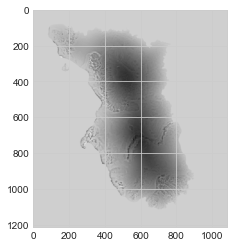

In [426]:
batchelor_topo_topo_diff_test = batchelor_topo_topo_diff.copy()
batchelor_topo_topo_diff_test[batchelor_topo_1_ice_mean[0]==0] = 0
plt.imshow(batchelor_topo_topo_diff_test)

In [431]:
batchelor_topo_1_topo_std_test = batchelor_topo_1_topo_std.copy()
batchelor_topo_1_topo_std_test[batchelor_topo_1_ice_mean[0]==0] = 0
batchelor_topo_1_topo_std_test.flatten()[np.argmax(batchelor_topo_topo_diff_test)]

245.3207859064218

In [427]:
np.max(batchelor_topo_topo_diff_test)

1476.2032303737642

In [423]:
np.nanmax(batchelor_topo_topo_diff)

2309.1022380828854

In [447]:
volume_to_sle(np.sum(batchelor_topo_1_ice_std * 5000**2))

13.07687913625252

In [442]:
np.nanargmin(batchelor_topo_ice_mean_diff[0][batchelor_topo_1_ice_mean[0]!=0])

356895

In [440]:
np.nanmean(batchelor_topo_ice_mean_diff[0][batchelor_topo_1_ice_mean[0]!=0])

-261.31794342680865

In [434]:
np.nanmean(batchelor_topo_topo_diff[batchelor_topo_1_ice_mean[0]!=0])

532.155063039369

In [408]:
volume_to_sle((np.nansum(batchelor_topo_1_topo_std))*5000**2)

3.193233755259213

In [409]:
((np.nansum(batchelor_topo_1_topo_std))*5000**2)/((10**3)**3)

1294251.863555395

# PGM Outputs

In [1153]:
! ls paper1_data/analytics

batchelor_topo_0_analytics.nc  batchelor_topo_1_analytics.nc


In [462]:
np.max(batchelor_icesheet_nroy_std[0])

1024.3025278865512

In [397]:
volume_to_sle(batchelor_icesheet_nroy_mean.sum()*5000**2)

51.16258073979383

In [390]:
batchelor_icesheet_mean.max(), batchelor_icesheet_std.flatten()[batchelor_icesheet_mean.argmax()]

(5076.812041099346, 925.289921293664)

In [391]:
batchelor_icesheet_nroy_mean.max(), batchelor_icesheet_nroy_std.flatten()[batchelor_icesheet_nroy_mean.argmax()]

(4288.58127873411, 719.0091169793739)

5076.812041099346

In [60]:
! ls 

glac1d_analytics.nc		      ice6g_corners_icesheet.nc
glac1d_corners_icesheet_analytics.nc  ice6g_icesheet_analytics.nc
glac1d_icesheet_analytics.nc	      implausibility_tidy.ipynb
glac1d_icesheet_corners.nc	      paper1_analytics.ipynb
hist_match_lgm_corners.nc	      paper1_data
hist_match_lgm_lhs.nc		      paper1_implausibility.ipynb
history_match.nc		      paper1_plots
history_match_pgm.nc		      paper1_plots.ipynb
ice6g_analytics.nc		      pgm_dist.png
ice6g_corners_icesheet_analytics.nc   Untitled.ipynb


(35.632901158291276, 59.66821767329737, 51.16258073979387)

In [453]:
np.min(pgm_nroy_vols)

35.632901158291276

In [183]:
ice6g_icesheet_analytics_ds = xr.open_dataset("ice6g_icesheet_analytics.nc")
glac1d_icesheet_analytics_ds = xr.open_dataset("glac1d_icesheet_analytics.nc")

In [1174]:
batchelor_topo_0_analytics_ds = xr.open_dataset("paper1_data/analytics/batchelor_topo_0_analytics.nc")
(batchelor_topo_0_analytics_ds.ice_volume_sle.values.flatten()).mean(), (batchelor_topo_0_analytics_ds.ice_volume_sle.values.flatten()).std()



(52.237358485272715, 8.216994640251652)

In [1341]:
1 - np.sum(nroy_pgm)/200

0.87

In [1195]:
np.arange(200)[nroy_pgm][pgm_vols[nroy_pgm].argmin()]

183

In [1330]:
(batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()).mean(), (batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()).std()


(59.44549407971307, 9.34968235398835)

In [1331]:
(batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()[nroy_pgm]).mean(), (batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()[nroy_pgm]).std()

(51.16258073979387, 6.127434985252672)

In [ ]:
pgm_std = np.std(batchelor_topo_1_ds.ice_thickness.values[nroy_pgm])
(pgm_std[pgm_std!=0]).mean()

In [1170]:
pgm_std = batchelor_topo_1_ds.ice_thickness_std.values
(pgm_std[pgm_std!=0]).mean()

474.44784953860744

In [1161]:
(batchelor_topo_1_analytics_ds.ice_volume_sle.values.flatten()[nroy_pgm]).mean()

51.16258073979387

In [473]:
batchelor_topo_1_analytics_ds.ice_volume_sle.values[:,0].shape

(200,)

In [476]:
pd.read_csv("paper1_data/icesheet_runs/batchelor/lhs_values.csv").columns

Index(['g_lgm_ice_streams_ice_stream', 'g_sediment_marine_sediment',
       'g_sediment_onshore_sediment', 'g_sediment_bedrock',
       'p_ice_stream_interior_dist', 'p_cold_ice_shear_stress',
       'p_cold_ice_interior_dist', 'p_hybrid_ice_stream_shear_stress',
       'p_hybrid_ice_stream_dist'],
      dtype='object')

In [485]:
batchelor_topo_1_analytics_ds.ice_volume_sle.values[:,0][nroy_pgm].min()

35.632901158291276

In [ ]:
xr.open_dataset("paper1_data/icesheet_runs/batchelor/batchelor_topo_1.nc").basal_shearstress.mean(axis=(1,2,3))

In [489]:
! mkdir paper1_plots/pgm_vol

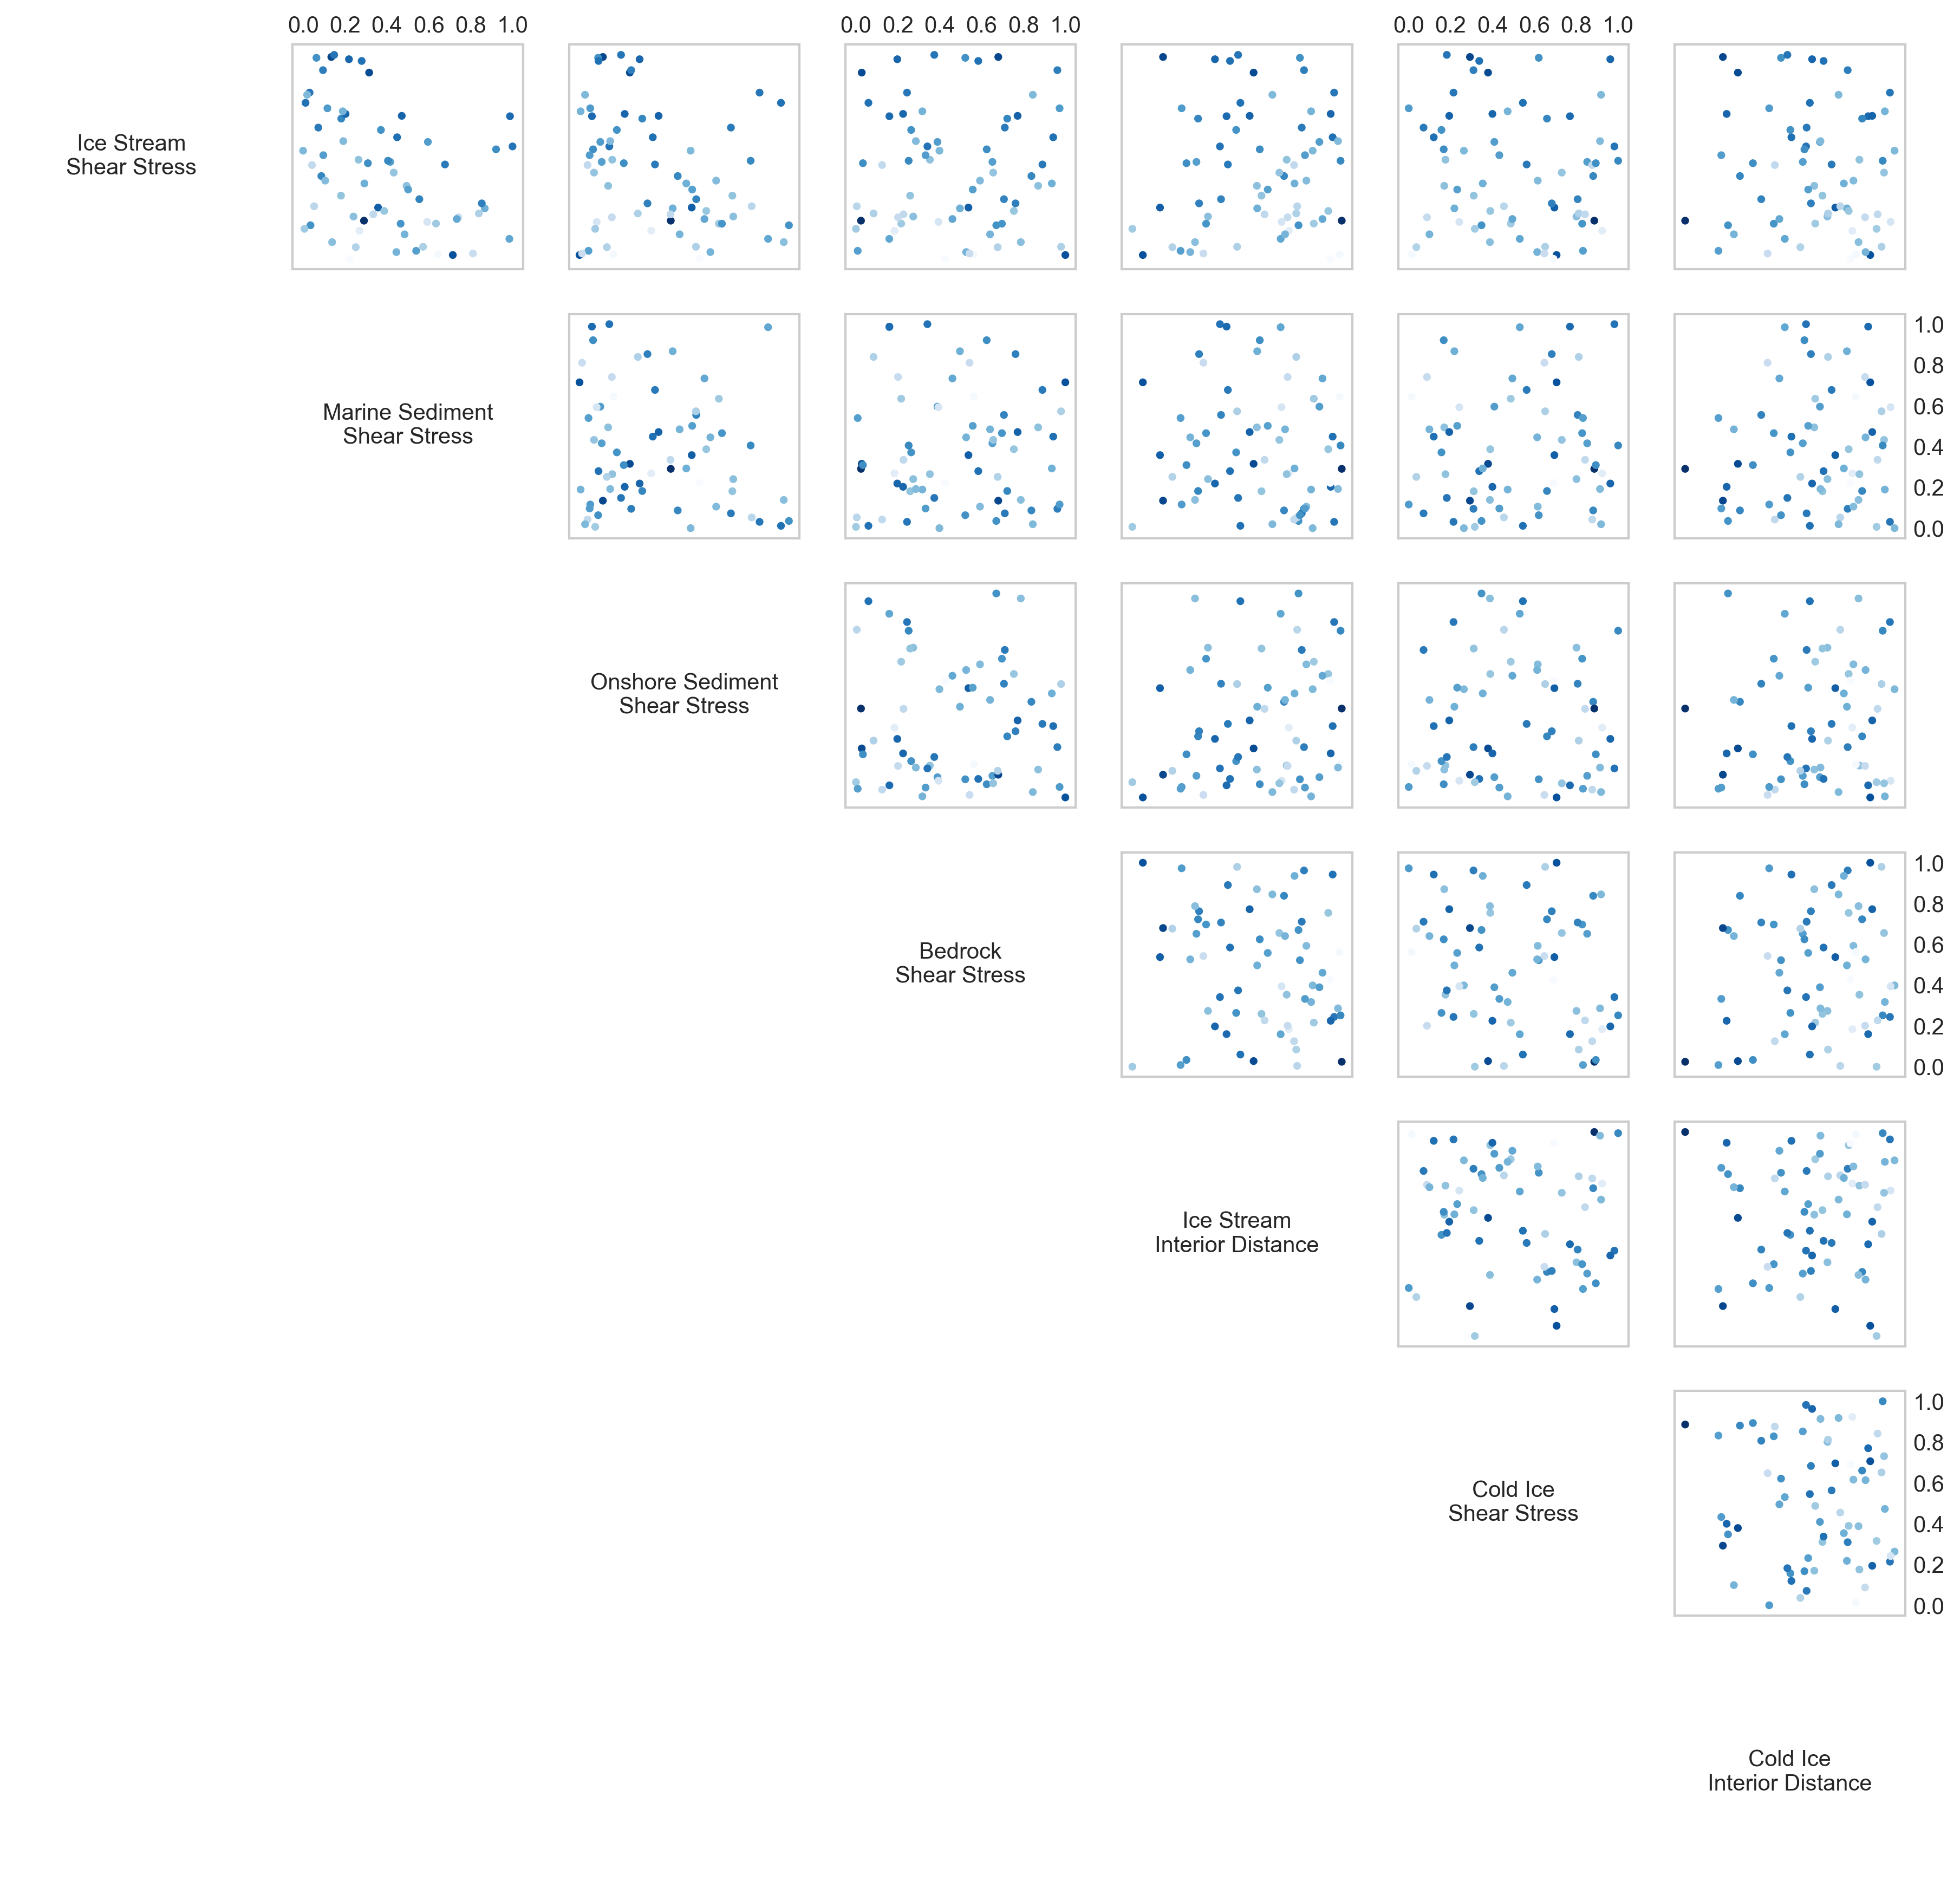

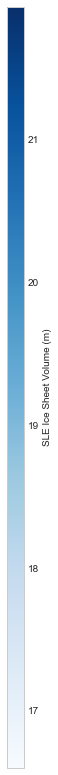

In [497]:
pgm_lhs_df = pd.read_csv("paper1_data/icesheet_runs/batchelor/lhs_values.csv")
pgm_param_vals = pgm_lhs_df.to_numpy()
from itertools import combinations


fig, ax, img = param_plot(
    ld_param_names,# + ['Hybrid Ice Stream\nShear Stress', 'Hybrid Ice Stream\nInterior Distance'], 
    ld_param_vals[nroy], 
    data=ice6g_icesheet_analytics_ds.ice_volume_sle.values[:,0][nroy], 
    plot_kwargs={"cmap": "Blues"}#, "vmin": 35, "vmax":60}
)

#fig.savefig("paper1_plots/pgm_vol/pgm_vol_a.png", dpi=300, bbox_inches="tight")



fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    #ticks=np.linspace(35,60,num=6), 
    label="SLE Ice Sheet Volume (m)",  
    shrink=0.7,
    aspect=40,
)
#fig.savefig(f"paper1_plots/pgm_vol/pgm_vol_1.png", dpi=300, bbox_inches="tight")




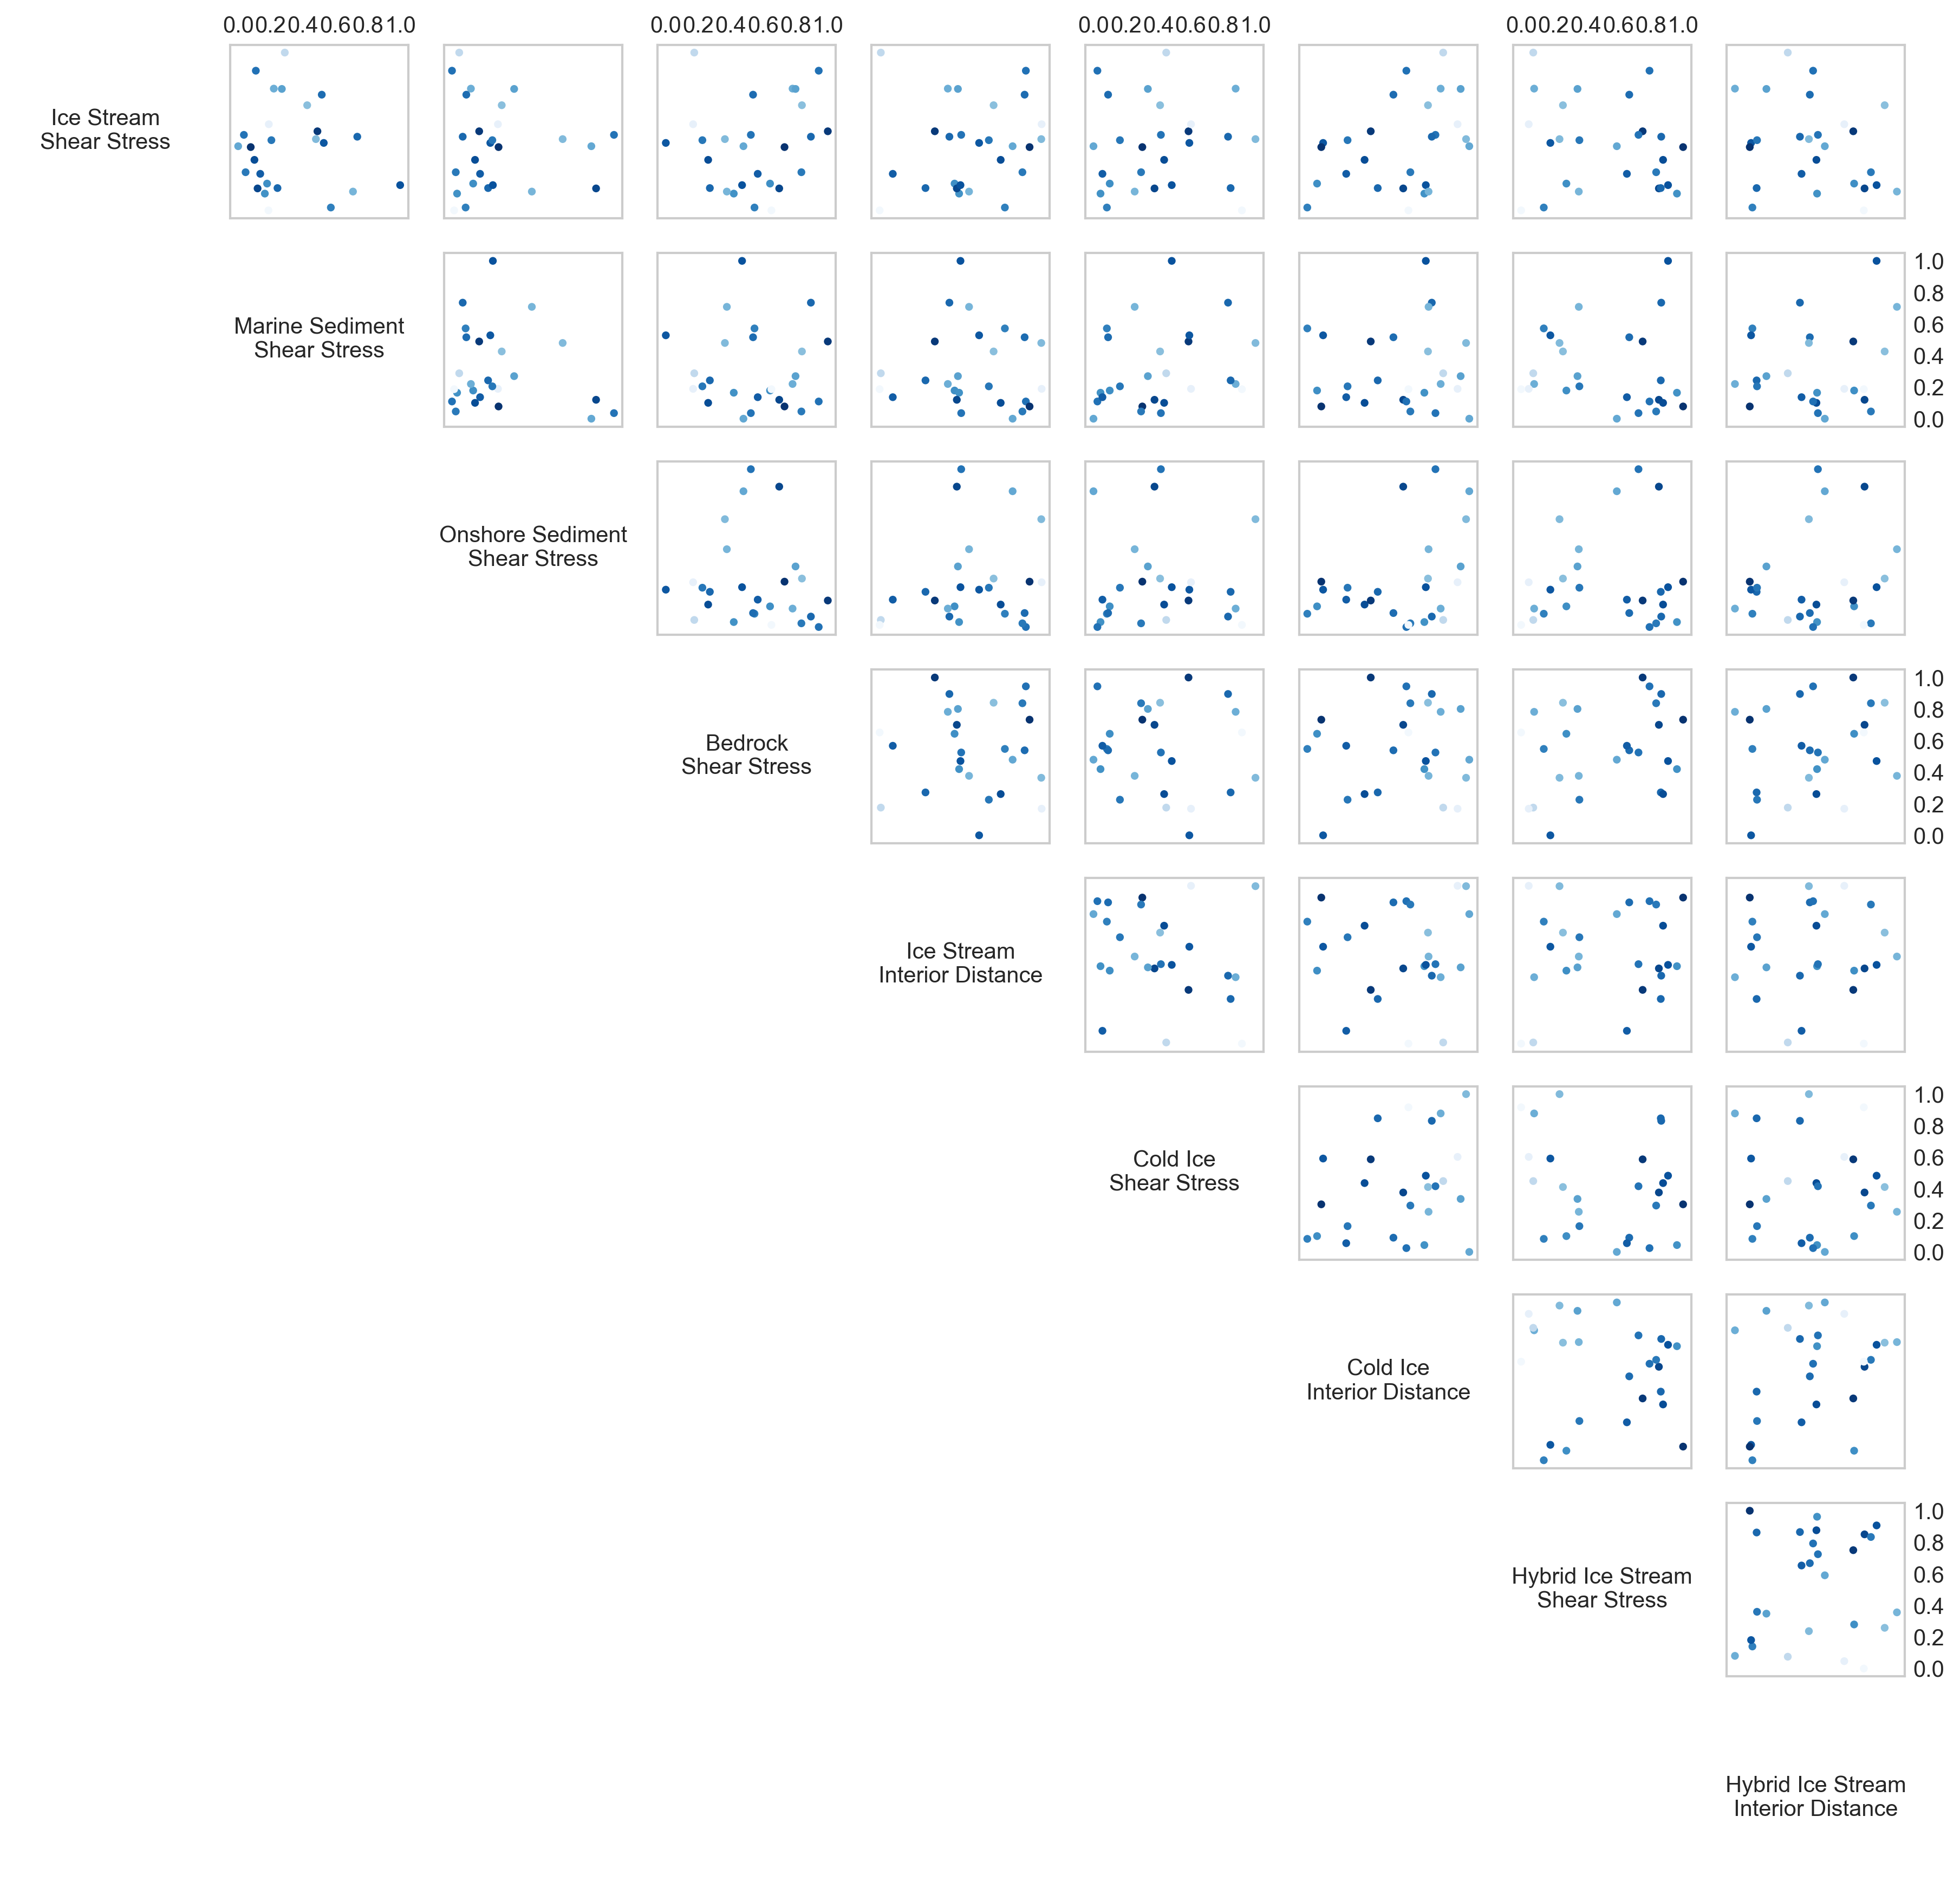

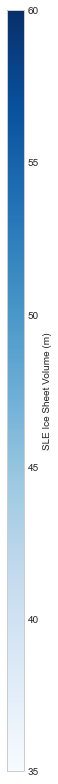

In [490]:
pgm_lhs_df = pd.read_csv("paper1_data/icesheet_runs/batchelor/lhs_values.csv")
pgm_param_vals = pgm_lhs_df.to_numpy()
from itertools import combinations


fig, ax, img = param_plot(
    ld_param_names + ['Hybrid Ice Stream\nShear Stress', 'Hybrid Ice Stream\nInterior Distance'], 
    pgm_param_vals[nroy_pgm], 
    data=batchelor_topo_1_analytics_ds.ice_volume_sle.values[:,0][nroy_pgm], 
    plot_kwargs={"cmap": "Blues", "vmin": 35, "vmax":60}
)

fig.savefig("paper1_plots/pgm_vol/pgm_vol_a.png", dpi=300, bbox_inches="tight")



fig, ax = plt.subplots(figsize=[.3,14])
fig.colorbar(
    img,
    cax=ax,
    ticks=np.linspace(35,60,num=6), 
    label="SLE Ice Sheet Volume (m)",  
    shrink=0.7,
    aspect=40,
)
fig.savefig(f"paper1_plots/pgm_vol/pgm_vol_1.png", dpi=300, bbox_inches="tight")




In [491]:
plot_ext = "paper1_plots/pgm_vol/pgm_vol_"

plot_width, plot_height = Image.open(f"{plot_ext}a.png").size
cbar_width, cbar_height = Image.open(f"{plot_ext}1.png").size

"""
Layout
A1
"""
total_width = plot_width + cbar_width
total_height = plot_height
new_im = Image.new('RGB', (total_width, total_height),color=(255,255,255,0))

cbar_offset = int(0.5*(plot_height) - 0.5*cbar_height)

im = Image.open(f"{plot_ext}a.png")
new_im.paste(im, (0,0))
im = Image.open(f"{plot_ext}1.png")
new_im.paste(im, (plot_width,cbar_offset))

new_im.save('paper1_plots/pgm_vol.png')

# Supplementary